### Full DnW Conversion ###

Converting both temperature to demand and wind speed to wind power generation, then taking the difference to calculate demand net wind. All in the same notebook.

Wind speed -> Wind power generation conversion first

In [1]:
%matplotlib inline

# Local imports
import os
import sys
import time
import argparse
import warnings

# Third-party imports
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import shapely.geometry
import cartopy.io.shapereader as shpreader
import iris

# Specific imports
from tqdm import tqdm
from datetime import datetime, timedelta

from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score

# Suppress warnings
warnings.filterwarnings('ignore')

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
# Load my specific functions
sys.path.append("/home/users/benhutch/unseen_functions")
from functions import (
    plot_distributions_fidelity,
    plot_cdfs,
    plot_qq,
    plot_rp_extremes,
    estimate_period,
    sigmoid,
    apply_detrend,
)

In [3]:
# Set up the output directory for the dfs
output_dir_dfs = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs"

# Load the model data
df_model_sfcWind = pd.read_csv(
    f"{output_dir_dfs}/HadGEM3-GC31-MM_dcppA-hindcast_sfcWind_United_Kingdom_1960-2018_day.csv"
)

# set up the df obs sfcwing
df_obs_sfcWind = pd.read_csv(
    "/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs/ERA5_sfcWind_United_Kingdom_1960-2018_daily_2024-12-11.csv"
)

# load the clearheads data for wind generation
df_ch = pd.read_csv(
    "/home/users/benhutch/unseen_multi_year/dfs/UK_clearheads_data_daily_1960_2018_ONDJFM.csv"
)

In [4]:
# Clean the obs data
df_obs_sfcWind["time"] = pd.to_datetime(
    df_obs_sfcWind["time"], origin="1952-01-01", unit="D"
)

# subset the data to O, N, D, J, F, M
df_obs_sfcWind = df_obs_sfcWind[
    df_obs_sfcWind["time"].dt.month.isin([10, 11, 12, 1, 2, 3])
]

In [5]:
# subset the model to the correct years
winter_years = np.arange(1, 10 + 1)

# set up a new df to append to
df_model_ondjfm = pd.DataFrame()

# Loop over the winter years
for i, wyear in enumerate(winter_years):
    # Set up the leads to extract
    leads = np.arange(331 + (i * 360), 331 + 180 + (i * 360))

    # Extract the data
    df_model_leads_this = df_model_sfcWind[df_model_sfcWind["lead"].isin(leads)]

    # include a new column

    # Append to the new df
    df_model_ondjfm = pd.concat([df_model_ondjfm, df_model_leads_this])

In [6]:
df_ch.head()

,date,solar_power,100m_wind_speed,10m_wind_speed,solar_irradiance,ofs_cfs,ons_cfs,t2m_no_detrend,t2m_2020_detrend,United_Kingdom_demand,United_Kingdom_wd_demand,wind_gen,demand_net_wind,wd_demand_net_wind
0,1960-01-01,0.017302,7.625868,5.137020,47.696808,0.766016,0.298726,6.577980,7.835584,40.766836,41.666578,15.744187,25.022648,25.922391
1,1960-01-02,0.016300,4.930154,3.186221,44.535210,0.161353,0.101100,3.956466,5.214012,40.019199,43.863111,3.883881,36.135318,39.979230
2,1960-01-03,0.014511,7.249626,4.753627,39.765705,0.298246,0.266276,5.730921,6.988410,37.949476,42.640292,8.359369,29.590107,34.280923
3,1960-01-04,0.016632,9.558028,6.228839,46.044937,0.526643,0.363619,7.894082,9.151514,39.775870,40.584140,13.176714,26.599156,27.407426
4,1960-01-05,0.026247,8.874397,6.005377,71.949350,0.798906,0.376032,5.362875,6.620249,42.761398,42.761398,17.378747,25.382651,25.382651


In [7]:
df_obs_sfcWind.tail()

,time,data
21545,2018-12-27,2.477261
21546,2018-12-28,3.448565
21547,2018-12-29,5.573635
21548,2018-12-30,4.381348
21549,2018-12-31,5.464558


In [8]:
df_model_sfcWind.head()

,init_year,member,lead,data
0,1960,1,1,8.429288
1,1960,1,2,9.267500
2,1960,1,3,7.539931
3,1960,1,4,7.504783
4,1960,1,5,5.574239


In [9]:
# # Plot the distribution of 10m wind speed
# plot_distributions_fidelity(
#     obs_df=df_obs_sfcWind,
#     model_df=df_model_ondjfm,
#     obs_val_name="data",
#     model_val_name="data",
#     obs_time_name="time",
#     model_time_name="init_year",
#     model_member_name="member",
#     model_lead_name="lead",
#     title="Distribution ONDJFM UK 10m Wind Speed (GW)",
#     nboot=10,
#     figsize=(12, 6),
#     fname_prefix="UK_10m_wind_speed_ONDJFM_fidelity",
#     save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
# )

Now fit the sigmoid

In [10]:
# Set up an initial guess for the parameters based on the observed data
p0 = [
    max(df_ch["wind_gen"]),
    np.median(df_obs_sfcWind["data"]),
    1,
    min(df_ch["wind_gen"]),
]

# Fit the sigmoid curve to the data
popt, pcov = curve_fit(
    sigmoid, df_obs_sfcWind["data"], df_ch["wind_gen"], p0=p0, method="dogbox"
)

Density range: 0.0 to 0.056535721756982675
Contour interval: 0.01884524058566089


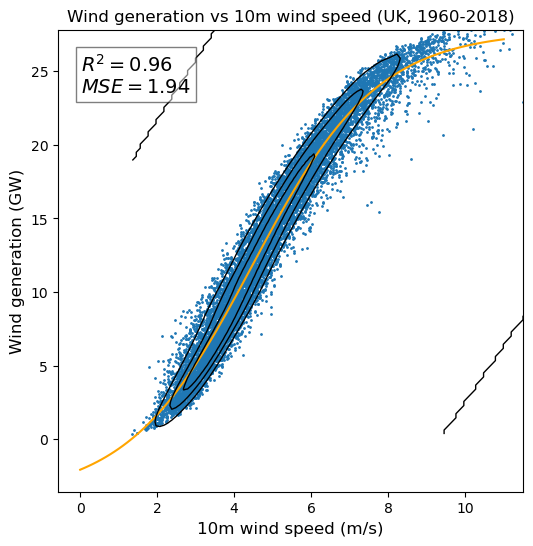

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.metrics import r2_score, mean_squared_error


# Assuming sigmoid and popt are already defined
# Define the sigmoid function if not already defined
def sigmoid(x, L, x0, k, b):
    return L / (1 + np.exp(-k * (x - x0))) + b


# Set up a figure
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the scatter of the data
ax.scatter(df_obs_sfcWind["data"], df_ch["wind_gen"], s=1)

# Plot the sigmoid fit
x = np.linspace(0, round(max(df_obs_sfcWind["data"])), 100)
ax.plot(
    x,
    sigmoid(x, *popt),
    "r-",
    label="fit: L=%5.3f, x0=%5.3f, k=%5.3f, b=%5.3f" % tuple(popt),
    color="orange",
)

# Calculate the density of the scatter points
xy = np.vstack([df_obs_sfcWind["data"], df_ch["wind_gen"]])
z = gaussian_kde(xy)(xy)

# Create a grid of points where you want to evaluate the density
xmin, xmax = df_obs_sfcWind["data"].min(), df_obs_sfcWind["data"].max()
ymin, ymax = df_ch["wind_gen"].min(), df_ch["wind_gen"].max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
density = gaussian_kde(xy)(positions).reshape(xx.shape)

# Determine the range of density values
density_min = density.min()
density_max = density.max()

# # Number of contour levels
levels = 3

# # Calculate the contour interval
contour_interval = (density_max - density_min) / levels

# # we want the contour interval to be 0.02 %
# contour_interval = 0.02

# # configure the levels
# levels = (density_max - density_min) / contour_interval

# # print the levels
# print(f"Levels: {levels}")

print(f"Density range: {density_min} to {density_max}")
print(f"Contour interval: {contour_interval}")

# Plot the density contours
ax.contour(xx, yy, density, levels=levels, colors="black", linewidths=1)

# Calculate the R^2 value
r2 = r2_score(df_ch["wind_gen"], sigmoid(df_obs_sfcWind["data"], *popt))

# Calculate the mean squared error
mse = mean_squared_error(df_ch["wind_gen"], sigmoid(df_obs_sfcWind["data"], *popt))

# Include these values in a textbox in the top left
textstr = "\n".join((r"$R^2=%.2f$" % (r2,), r"$MSE=%.2f$" % (mse,)))

ax.text(
    0.05,
    0.95,
    textstr,
    transform=ax.transAxes,
    fontsize=14,
    verticalalignment="top",
    horizontalalignment="left",
    bbox=dict(facecolor="white", alpha=0.5),
)

# Set the labels
ax.set_xlabel("10m wind speed (m/s)", fontsize=12)
ax.set_ylabel("Wind generation (GW)", fontsize=12)

# Set the title
ax.set_title("Wind generation vs 10m wind speed (UK, 1960-2018)")

plt.show()

Fit looks good. Now we want to evaluate the performance of the converted model wind generation in terms of statistics.

In [12]:
# First create a column in the obs using the sigmoid function
df_obs_sfcWind["wind_gen_sigmoid"] = sigmoid(df_obs_sfcWind["data"], *popt)

Density range: 0.0 to 0.013703024744784043
Contour interval: 0.004567674914928014


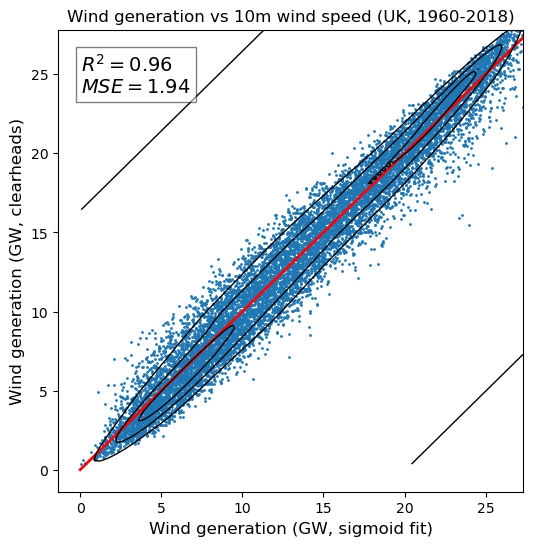

In [13]:
# Set up a figure
fig, ax = plt.subplots(figsize=(6, 6))

# Plot the scatter of the data
ax.scatter(df_obs_sfcWind["wind_gen_sigmoid"], df_ch["wind_gen"], s=1)

# plot the 1:1 line as a solid black line
ax.plot(
    [0, max(df_obs_sfcWind["wind_gen_sigmoid"])],
    [0, max(df_obs_sfcWind["wind_gen_sigmoid"])],
    color="red",
    linestyle="-",
    linewidth=2,
)

# Calculate the density of the scatter points
xy = np.vstack([df_obs_sfcWind["wind_gen_sigmoid"], df_ch["wind_gen"]])
z = gaussian_kde(xy)(xy)

# Create a grid of points where you want to evaluate the density
xmin, xmax = (
    df_obs_sfcWind["wind_gen_sigmoid"].min(),
    df_obs_sfcWind["wind_gen_sigmoid"].max(),
)
ymin, ymax = df_ch["wind_gen"].min(), df_ch["wind_gen"].max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
density = gaussian_kde(xy)(positions).reshape(xx.shape)

# Determine the range of density values
density_min = density.min()
density_max = density.max()

# # Number of contour levels
levels = 3

# # Calculate the contour interval
contour_interval = (density_max - density_min) / levels

# # we want the contour interval to be 0.02 %
# contour_interval = 0.02

# # configure the levels
# levels = (density_max - density_min) / contour_interval

# # print the levels
# print(f"Levels: {levels}")

print(f"Density range: {density_min} to {density_max}")
print(f"Contour interval: {contour_interval}")

# Plot the density contours
ax.contour(xx, yy, density, levels=levels, colors="black", linewidths=1)

# Calculate the R^2 value
r2 = r2_score(df_ch["wind_gen"], df_obs_sfcWind["wind_gen_sigmoid"])

# Calculate the mean squared error
mse = mean_squared_error(df_ch["wind_gen"], df_obs_sfcWind["wind_gen_sigmoid"])

# Include these values in a textbox in the top left
textstr = "\n".join((r"$R^2=%.2f$" % (r2,), r"$MSE=%.2f$" % (mse,)))

ax.text(
    0.05,
    0.95,
    textstr,
    transform=ax.transAxes,
    fontsize=14,
    verticalalignment="top",
    horizontalalignment="left",
    bbox=dict(facecolor="white", alpha=0.5),
)

# Set the labels
ax.set_xlabel("Wind generation (GW, sigmoid fit)", fontsize=12)
ax.set_ylabel("Wind generation (GW, clearheads)", fontsize=12)

# Set the title
ax.set_title("Wind generation vs 10m wind speed (UK, 1960-2018)")

plt.show()

Sigmoid fit does a pretty good job of replicating the clearheads wind generation, albeit with +- 2/3 GW of uncertainty.

Now apply the same sigmoid fit to the model 10m wind speed data.

In [14]:
df_model_ondjfm_sfcWind = df_model_ondjfm.copy()

In [15]:
df_model_ondjfm_sfcWind["wind_gen_sigmoid"] = sigmoid(
    df_model_ondjfm_sfcWind["data"], *popt
)

In [16]:
# # Compare the wind generation distribution from the model and the obs
# plot_distributions_fidelity(
#     obs_df=df_ch,
#     model_df=df_model_ondjfm,
#     obs_val_name="wind_gen", # CLEARHEADS ground-truth
#     model_val_name="wind_gen_sigmoid", # 10m wind speed sigmoid fit
#     obs_time_name="time",
#     model_time_name="init_year",
#     model_member_name="member",
#     model_lead_name="lead",
#     title="Distribution ONDJFM UK Wind Generation (GW)",
#     nboot=1000,
#     figsize=(12, 6),
#     fname_prefix="UK_wind_generation_ONDJFM_fidelity",
#     save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
# )

### Temperature -> demand ###

Do the conversion from temperature to demand.

In [17]:
# load the model data
df_model_tas = pd.read_csv(
    f"{output_dir_dfs}/HadGEM3-GC31-MM_dcppA-hindcast_tas_United_Kingdom_1960-2018_day.csv"
)

# subset the model to the correct years
winter_years = np.arange(1, 10 + 1)

# set up a new df to append to
df_model_ondjfm = pd.DataFrame()

# Loop over the winter years
for i, wyear in enumerate(winter_years):
    # Set up the leads to extract
    leads = np.arange(331 + (i * 360), 331 + 180 + (i * 360))

    # Extract the data
    df_model_leads_this = df_model_tas[df_model_tas["lead"].isin(leads)]

    # include a new column

    # Append to the new df
    df_model_ondjfm = pd.concat([df_model_ondjfm, df_model_leads_this])

# set up a new df to append to
df_model_ondjfm_wyear = pd.DataFrame()

# Loop over the winter years
for i, wyear in enumerate(winter_years):
    # Set up the leads to extract
    leads = np.arange(331 + (i * 360), 331 + 180 + (i * 360))

    # Extract the data
    df_model_leads_this = df_model_ondjfm[df_model_ondjfm["lead"].isin(leads)]

    # include a new column containing the winter year
    df_model_leads_this["winter_year"] = wyear

    # Append to the new df
    df_model_ondjfm_wyear = pd.concat([df_model_ondjfm_wyear, df_model_leads_this])

# add a new column for temp c in the model data
df_model_ondjfm_wyear["data_c"] = df_model_ondjfm_wyear["data"] - 273.15

# create a new column in df_model_ondjfm_wyear - effective_dec_year
df_model_ondjfm_wyear["effective_dec_year"] = (
    df_model_ondjfm_wyear["init_year"] + df_model_ondjfm_wyear["winter_year"]
)

# load the obs data
df_obs_tas = pd.read_csv(
    f"{output_dir_dfs}/ERA5_tas_United_Kingdom_1960-2018_daily_2024-11-26.csv"
)

# Convert the 'time' column to datetime, assuming it represents days since "1950-01-01 00:00:00"
df_obs_tas["time"] = pd.to_datetime(df_obs_tas["time"], origin="1950-01-01", unit="D")

# subset the obs data to O, N, D, J, F, M
df_obs_tas = df_obs_tas[df_obs_tas["time"].dt.month.isin([10, 11, 12, 1, 2, 3])]

# new column for temp in C
df_obs_tas["data_c"] = df_obs_tas["data"] - 273.15

In [18]:
%%time

# Apply the detrend function to the data
df_obs_tas, df_model_tas = apply_detrend(
    obs_df=df_obs_tas,
    model_df=df_model_ondjfm_wyear,
    obs_val_name="data_c",
    model_val_name="data_c",
    obs_time_name="time",
    model_time_name="effective_dec_year",
    model_member_name="member",
    model_lead_name="lead",
)

The mean slope is 0.030071677811841058
The 2.5th percentile of the slopes is -0.013596000239910108
The 97.5th percentile of the slopes is 0.07067023285905695
The slope of the observations is 0.029431150102115586
The trend line obs is [4.0252645  4.0252645  4.0252645  ... 6.04006692 6.04006692 6.04006692]
The trend line model is [4.0252645  4.0252645  4.0252645  ... 6.04006692 6.04006692 6.04006692]
The trend final is 6.040066916249145
The trend final obs is 5.739350138130732
The model_val_name is data_c
The obs_val_name is data_c
The mean of the model data is 6.0440047854461305
The mean of the obs data is 6.083428703753268
CPU times: user 48.4 s, sys: 9.43 ms, total: 48.4 s
Wall time: 49.2 s


In [19]:
# # Validate the detrended temperature
# plot_distributions_fidelity(
#     obs_df=df_obs_tas,
#     model_df=df_model_tas,
#     obs_val_name="data_c_dt",
#     model_val_name="data_c_dt",
#     obs_time_name="time",
#     model_time_name="init_year",
#     model_member_name="member",
#     model_lead_name="lead",
#     title="Distribution ONDJFM UK temperature (C) detrended",
#     nboot=1000,
#     figsize=(12, 6),
#     fname_prefix="UK_detr_temp_ONDJFM_fidelity",
#     save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
# )

Now convert to demand through HDD, CDD, and the regression relationships.

In [20]:
# Set up hdd and cdd
hdd_base = 15.5
cdd_base = 22.0

# Process the obs data
df_obs_tas["hdd_dt"] = df_obs_tas["data_c_dt"].apply(lambda x: max(0, hdd_base - x))
df_obs_tas["cdd_dt"] = df_obs_tas["data_c_dt"].apply(lambda x: max(0, x - cdd_base))

# process the model data
df_model_tas["hdd_dt"] = df_model_tas["data_c_dt"].apply(lambda x: max(0, hdd_base - x))
df_model_tas["cdd_dt"] = df_model_tas["data_c_dt"].apply(lambda x: max(0, x - cdd_base))

In [21]:
# Set up the path to the regression coeffs
regr_coeffs = (
    "/home/users/benhutch/ERA5_energy_update/ERA5_Regression_coeffs_demand_model.csv"
)

# load the regression coeffs
df_regr = pd.read_csv(regr_coeffs)

# Set the index
df_regr.set_index("Unnamed: 0", inplace=True)

# Rename the columns by splitting by _ and extracting the second element
df_regr.columns = [x.split("_")[0] for x in df_regr.columns]

# if there is a column called "United" replace it with "United Kingdom"
if "United" in df_regr.columns:
    df_regr.rename(columns={"United": "United_Kingdom"}, inplace=True)

# extract the coeffs for the UK
time_coeff_uk = df_regr.loc["time", "United_Kingdom"]
hdd_coeff_uk = df_regr.loc["HDD", "United_Kingdom"]
cdd_coeff_uk = df_regr.loc["CDD", "United_Kingdom"]

# Calculate the obs demand detrended
df_obs_tas["UK_demand_dt"] = (
    (time_coeff_uk * 2017)  # demand year which the model is based on
    + (hdd_coeff_uk * df_obs_tas["hdd_dt"])
    + (cdd_coeff_uk * df_obs_tas["cdd_dt"])
)

# Calculate the model demand detrended
df_model_tas["UK_demand_dt"] = (
    (time_coeff_uk * 2017)  # demand year which the model is based on
    + (hdd_coeff_uk * df_model_tas["hdd_dt"])
    + (cdd_coeff_uk * df_model_tas["cdd_dt"])
)

In [22]:
# # Now validate the UK demand against the observed data
# plot_distributions_fidelity(
#     obs_df=df_obs_tas,
#     model_df=df_model_tas,
#     obs_val_name="UK_demand_dt",
#     model_val_name="UK_demand_dt",
#     obs_time_name="time",
#     model_time_name="init_year",
#     model_member_name="member",
#     model_lead_name="lead",
#     title="Distribution ONDJFM UK demand (GW) detrended",
#     nboot=1000,
#     figsize=(12, 6),
#     fname_prefix="UK_detr_demand_ONDJFM_fidelity",
#     save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
# )

### Demand net wind ###

Now merge the dataframes to look at the demand net wind.

In [23]:
# merge the obs data
df_obs = df_obs_sfcWind.merge(df_obs_tas, on="time", how="inner")

In [24]:
# rename data_x as "10m_wind_speed" and data_y as "temp_K"
df_obs.rename(columns={"data_x": "10m_wind_speed", "data_y": "temp_K"}, inplace=True)

In [25]:
df_model_ondjfm_sfcWind.head()

,init_year,member,lead,data,wind_gen_sigmoid
330,1960,1,331,4.469876,11.806168
331,1960,1,332,5.489894,16.641298
332,1960,1,333,6.172364,19.457478
333,1960,1,334,4.134217,10.172521
334,1960,1,335,4.603901,12.460984


In [26]:
df_model_ondjfm_sfcWind.rename(columns={"data": "10m_wind_speed"}, inplace=True)
df_model_tas.rename(columns={"data": "temp_K"}, inplace=True)

In [27]:
# Merge the model data on "init_year", "lead", and "member"
df_model = df_model_ondjfm_sfcWind.merge(
    df_model_tas, on=["init_year", "lead", "member"], how="inner"
)

In [28]:
df_ch.head()

,date,solar_power,100m_wind_speed,10m_wind_speed,solar_irradiance,ofs_cfs,ons_cfs,t2m_no_detrend,t2m_2020_detrend,United_Kingdom_demand,United_Kingdom_wd_demand,wind_gen,demand_net_wind,wd_demand_net_wind
0,1960-01-01,0.017302,7.625868,5.137020,47.696808,0.766016,0.298726,6.577980,7.835584,40.766836,41.666578,15.744187,25.022648,25.922391
1,1960-01-02,0.016300,4.930154,3.186221,44.535210,0.161353,0.101100,3.956466,5.214012,40.019199,43.863111,3.883881,36.135318,39.979230
2,1960-01-03,0.014511,7.249626,4.753627,39.765705,0.298246,0.266276,5.730921,6.988410,37.949476,42.640292,8.359369,29.590107,34.280923
3,1960-01-04,0.016632,9.558028,6.228839,46.044937,0.526643,0.363619,7.894082,9.151514,39.775870,40.584140,13.176714,26.599156,27.407426
4,1960-01-05,0.026247,8.874397,6.005377,71.949350,0.798906,0.376032,5.362875,6.620249,42.761398,42.761398,17.378747,25.382651,25.382651


In [29]:
# Calculate the demand_dt_net_wind
df_model["demand_dt_net_wind"] = df_model["UK_demand_dt"] - df_model["wind_gen_sigmoid"]

In [30]:
# Calculate the demand_dt_net_wind for the obs
df_obs["demand_dt_net_wind"] = df_obs["UK_demand_dt"] - df_ch["wind_gen"]

In [31]:
# # Compare the demand_dt_net_wind distribution from the model and the obs
# plot_distributions_fidelity(
#     obs_df=df_obs,
#     model_df=df_model,
#     obs_val_name="demand_dt_net_wind",  # Empirical demand - CH wind generation
#     model_val_name="demand_dt_net_wind",
#     obs_time_name="time",
#     model_time_name="init_year",
#     model_member_name="member",
#     model_lead_name="lead",
#     title="Distribution ONDJFM UK demand - wind generation (GW) detrended",
#     nboot=1000,
#     figsize=(12, 6),
#     fname_prefix="UK_detr_demand_net_wind_ONDJFM_fidelity",
#     save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
# )

Looks pretty good! No bias correction needed either!!

Now do the conversion into the number of exceedance days for the winter to look at the overall severity.

In [32]:
# If time is a column for obs df
df_obs["time"] = pd.to_datetime(df_obs["time"])

# Set time as the index
df_obs.set_index("time", inplace=True)

In [33]:
df_obs.columns

Index(['10m_wind_speed', 'wind_gen_sigmoid', 'temp_K', 'data_c', 'data_c_dt',
       'hdd_dt', 'cdd_dt', 'UK_demand_dt', 'demand_dt_net_wind'],
      dtype='object')

In [34]:
df_ch.columns

Index(['date', 'solar_power', '100m_wind_speed', '10m_wind_speed',
       'solar_irradiance', 'ofs_cfs', 'ons_cfs', 't2m_no_detrend',
       't2m_2020_detrend', 'United_Kingdom_demand', 'United_Kingdom_wd_demand',
       'wind_gen', 'demand_net_wind', 'wd_demand_net_wind'],
      dtype='object')

In [35]:
df_ch["date"] = pd.to_datetime(df_ch["date"])

df_ch.set_index("date", inplace=True)

Plot the histograms of wind generation. To decide the obs threshold to use for wind drought days.

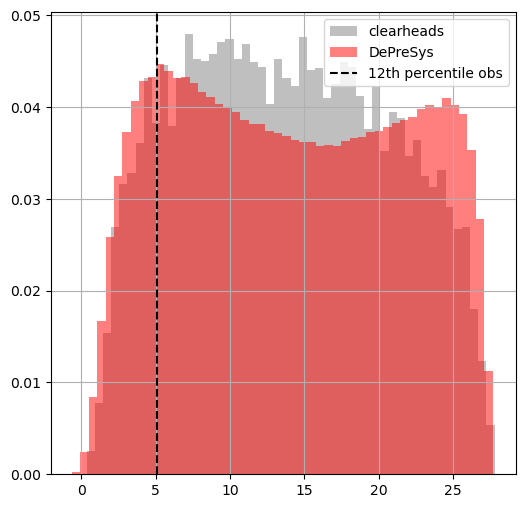

In [36]:
# set up a figure
fig, ax = plt.subplots(figsize=(6, 6))

# Plot a histogram of the wind generation clearheads
df_ch["wind_gen"].hist(
    bins=50, ax=ax, alpha=0.5, label="clearheads", color="gray", density=True
)

# Plot a histogram of the wind generation obs
df_model["wind_gen_sigmoid"].hist(
    bins=50, ax=ax, alpha=0.5, label="DePreSys", color="red", density=True
)

# plot a horizontal line for the 20th percentile of the obs
ax.axvline(
    df_ch["wind_gen"].quantile(0.12),
    color="black",
    linestyle="--",
    label="12th percentile obs",
)

# include a legend
ax.legend()

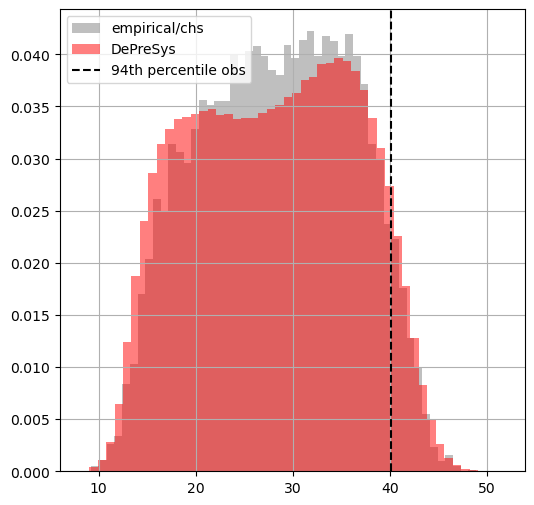

In [37]:
# Plot the distribution of the detrended demand - wind generation
fig, ax = plt.subplots(figsize=(6, 6))

# Plot a histogram of the demand net wind
df_obs["demand_dt_net_wind"].hist(
    bins=50, ax=ax, alpha=0.5, label="empirical/chs", color="gray", density=True
)

# Plot a histogram of the demand net wind
df_model["demand_dt_net_wind"].hist(
    bins=50, ax=ax, alpha=0.5, label="DePreSys", color="red", density=True
)

# plot a horizontal line for the 20th percentile of the obs
ax.axvline(
    df_obs["demand_dt_net_wind"].quantile(0.94),
    color="black",
    linestyle="--",
    label="94th percentile obs",
)

# include a legend in the top left
ax.legend(loc="upper left")

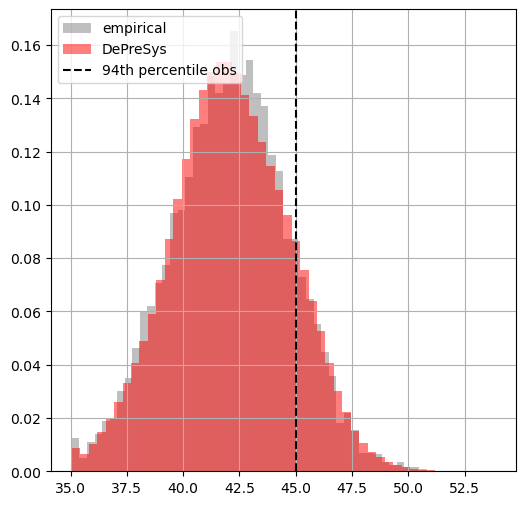

In [38]:
# plot the demand
fig, ax = plt.subplots(figsize=(6, 6))

# Plot a histogram of the demand net wind
df_obs["UK_demand_dt"].hist(
    bins=50, ax=ax, alpha=0.5, label="empirical", color="gray", density=True
)

# Plot a histogram of the demand net wind
df_model["UK_demand_dt"].hist(
    bins=50, ax=ax, alpha=0.5, label="DePreSys", color="red", density=True
)

# plot a horizontal line for the 20th percentile of the obs
ax.axvline(
    df_obs["UK_demand_dt"].quantile(0.87),
    color="black",
    linestyle="--",
    label="94th percentile obs",
)

# include a legend in the top left
ax.legend(loc="upper left")

12th percentile of wind generation considered as ~5 GW of generation, which is very low/unusual during the winter. Can always test and adjust.

94th percentile of detrended demand net wind ~ 40 GW identified by Ben Sloman at NESO.

87th percentile of detrended demand ~ 45 GW which is high.

In [39]:
# Therefore use the 92th percentile for exceedance
# loop over the winter years
winter_years = np.arange(1960, 2018 + 1)

# Set up an array to store the severity index
severity_index = np.zeros(len(winter_years))

# Set up an array to store the no. exceedance days
no_exceedance_days = np.zeros(len(winter_years))

# Set up an empty list for the dates
no_exceedance_days_demand = []
severity_index_demand = []

# Same for wind speed
no_undershoot_days_wind = []
severity_index_wind = []

# # Same for demand net wind
no_exceedance_days_demand_net_wind = []
severity_index_demand_net_wind = []

# 92 just chosen to be in line with demand net wind
# 87th percentile for demand ~ 45 GW
all_winters_high_demand = np.percentile(df_obs["UK_demand_dt"], 87)

# 94th percentile for demand net wind ~ 40 GW identified by Ben Sloman as being
# challenging
all_winters_high_DnW = np.percentile(df_obs["demand_dt_net_wind"], 94)

# 12th percentile of wind generation ~ 5 GW
# Which is pretty low during the winter
all_winters_low_wind = np.percentile(df_ch["wind_gen"], 12)

# loop over the winter years
for i, year in enumerate(winter_years):
    # Set up the first and last day of the winter
    winter_start = pd.Timestamp(f"{year}-10-01")
    winter_end = pd.Timestamp(f"{year+1}-03-31")

    # subset the data
    df = df_obs.loc[winter_start:winter_end]
    df_ch_this = df_ch.loc[winter_start:winter_end]

    # if df includes 29th feb, then drop this row
    if f"{year + 1}-02-29" in df.index:
        print("Dropping 29th Feb")
        df = df.drop(pd.Timestamp(f"{year + 1}-02-29"))

    # apply a boolean mask to the demand net wind value
    # which is true where the demand net wind is greater than the 80% tile value
    mask_demand = df["UK_demand_dt"] > all_winters_high_demand
    mask_DnW = df["demand_dt_net_wind"] > all_winters_high_DnW
    mask_wind = df_ch_this["wind_gen"] < all_winters_low_wind

    # calculate the severity index
    severity_index_demand_this = (
        df["UK_demand_dt"][mask_demand] - all_winters_high_demand
    ).sum()
    severity_index_demand_net_wind_this = (
        df["demand_dt_net_wind"][mask_DnW] - all_winters_high_DnW
    ).sum()
    severity_index_wind_this = (
        all_winters_low_wind - df_ch_this["wind_gen"][mask_wind]
    ).sum()

    # append these to the list
    severity_index_demand.append(severity_index_demand_this)
    severity_index_demand_net_wind.append(severity_index_demand_net_wind_this)
    severity_index_wind.append(severity_index_wind_this)

    # calculate the no. exceedance days
    no_exceedance_days_demand_this = mask_demand.sum()
    no_exceedance_days_demand_net_wind_this = mask_DnW.sum()
    no_undershoot_days_wind_this = mask_wind.sum()

    # append these to the list
    no_exceedance_days_demand.append(no_exceedance_days_demand_this)
    no_exceedance_days_demand_net_wind.append(no_exceedance_days_demand_net_wind_this)
    no_undershoot_days_wind.append(no_undershoot_days_wind_this)

# set up a dataframe for the number of exceedance days
df_exceedance_days_obs = pd.DataFrame(
    {
        "severity_index_demand": severity_index_demand,
        "no_exceedance_days_demand": no_exceedance_days_demand,
        "severity_index_demand_net_wind": severity_index_demand_net_wind,
        "no_exceedance_days_demand_net_wind": no_exceedance_days_demand_net_wind,
        "severity_index_wind": severity_index_wind,
        "no_undershoot_days_wind": no_undershoot_days_wind,
    },
    index=winter_years,
)

Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb
Dropping 29th Feb


In [40]:
df_model.columns

Index(['init_year', 'member', 'lead', '10m_wind_speed', 'wind_gen_sigmoid',
       'temp_K', 'winter_year', 'data_c', 'effective_dec_year', 'data_c_dt',
       'hdd_dt', 'cdd_dt', 'UK_demand_dt', 'demand_dt_net_wind'],
      dtype='object')

No pre-bias correction of the model data necessary in this case.

In [41]:
# Extract the unique init years
init_years = df_model["init_year"].unique()
members = df_model["member"].unique()
winter_years = df_model["winter_year"].unique()

# Set up an array to store the severity index
model_severity_index_demand = np.zeros(
    [len(init_years), len(members), len(winter_years)]
)
model_no_exceedance_days_demand = np.zeros(
    [len(init_years), len(members), len(winter_years)]
)

# Same but for demand net wind
model_severity_index_demand_net_wind = np.zeros(
    [len(init_years), len(members), len(winter_years)]
)
model_no_exceedance_days_demand_net_wind = np.zeros(
    [len(init_years), len(members), len(winter_years)]
)

# Same but for wind generation
model_severity_index_wind = np.zeros([len(init_years), len(members), len(winter_years)])
model_no_undershoot_days_wind = np.zeros(
    [len(init_years), len(members), len(winter_years)]
)

# Set up an empty list for the dates
model_dates_exceedance_values = []
model_exceedance_values = []
winter_mean_dnw = []

# Set up an empty df
df_model_exceedance = pd.DataFrame()

# loop over the init years
for i, i_year in enumerate(init_years):
    for j, member in enumerate(members):
        for k, w_year in enumerate(winter_years):
            # Constrain to the init year, member and winter year
            df_this = df_model[
                (df_model["init_year"] == i_year)
                & (df_model["member"] == member)
                & (df_model["winter_year"] == w_year)
            ]

            # apply a boolean mask to the demand net wind value
            # which is true where the demand net wind is greater than the 80% tile value
            mask_demand = df_this["UK_demand_dt"] > all_winters_high_demand
            mask_DnW = df_this["demand_dt_net_wind"] > all_winters_high_DnW
            mask_wind = df_this["wind_gen_sigmoid"] < all_winters_low_wind

            # calculate the severity index
            model_severity_index_demand[i, j, k] = (
                df_this["UK_demand_dt"][mask_demand] - all_winters_high_demand
            ).sum()
            model_severity_index_demand_net_wind[i, j, k] = (
                df_this["demand_dt_net_wind"][mask_DnW] - all_winters_high_DnW
            ).sum()
            model_severity_index_wind[i, j, k] = (
                all_winters_low_wind - df_this["wind_gen_sigmoid"][mask_wind]
            ).sum()

            # calculate the no. exceedance days
            model_no_exceedance_days_demand[i, j, k] = mask_demand.sum()
            model_no_exceedance_days_demand_net_wind[i, j, k] = mask_DnW.sum()
            model_no_undershoot_days_wind[i, j, k] = mask_wind.sum()

            # # winter mean values
            # winter_mean_dnw.append(df_this["wd_demand_net_wind_pred_bc"].mean())

            # Set up the df
            df_this_exceedance = pd.DataFrame(
                {
                    "init_year": [i_year],
                    "member": [member],
                    "winter_year": [w_year],
                    "severity_index_demand": [model_severity_index_demand[i, j, k]],
                    "no_exceedance_days_demand": [
                        model_no_exceedance_days_demand[i, j, k]
                    ],
                    "severity_index_demand_net_wind": [
                        model_severity_index_demand_net_wind[i, j, k]
                    ],
                    "no_exceedance_days_demand_net_wind": [
                        model_no_exceedance_days_demand_net_wind[i, j, k]
                    ],
                    "severity_index_wind": [model_severity_index_wind[i, j, k]],
                    "no_undershoot_days_wind": [model_no_undershoot_days_wind[i, j, k]],
                }
            )

            # Append to the df
            df_model_exceedance = pd.concat([df_model_exceedance, df_this_exceedance])

In [42]:
# Create the effective_dec_year column
df_model_exceedance["effective_dec_year"] = (
    df_model_exceedance["init_year"] + df_model_exceedance["winter_year"]
)

In [43]:
import importlib

importlib.reload(sys.modules["functions"])
from functions import dot_plot

In [44]:
df_exceedance_days_obs.head()

,severity_index_demand,no_exceedance_days_demand,severity_index_demand_net_wind,no_exceedance_days_demand_net_wind,severity_index_wind,no_undershoot_days_wind
1960,0.790387,2,8.833997,7,49.157260,27
1961,27.877418,24,26.456997,15,53.891523,31
1962,117.716482,67,67.184280,26,53.061683,32
1963,9.360300,12,8.456894,8,38.369448,31
1964,22.499508,22,9.901393,7,44.089426,28


Bad events have high values
Saving plot to /gws/nopw/j04/canari/users/benhutch/plots/unseen/obs-no_exceedance_days_demand_net_wind_model-no_exceedance_days_demand_net_wind_quantile-0.8_solid-max_dot_plot_2024-12-18-14-26-00.pdf
Saved plot to /gws/nopw/j04/canari/users/benhutch/plots/unseen/obs-no_exceedance_days_demand_net_wind_model-no_exceedance_days_demand_net_wind_quantile-0.8_solid-max_dot_plot_2024-12-18-14-26-00.pdf


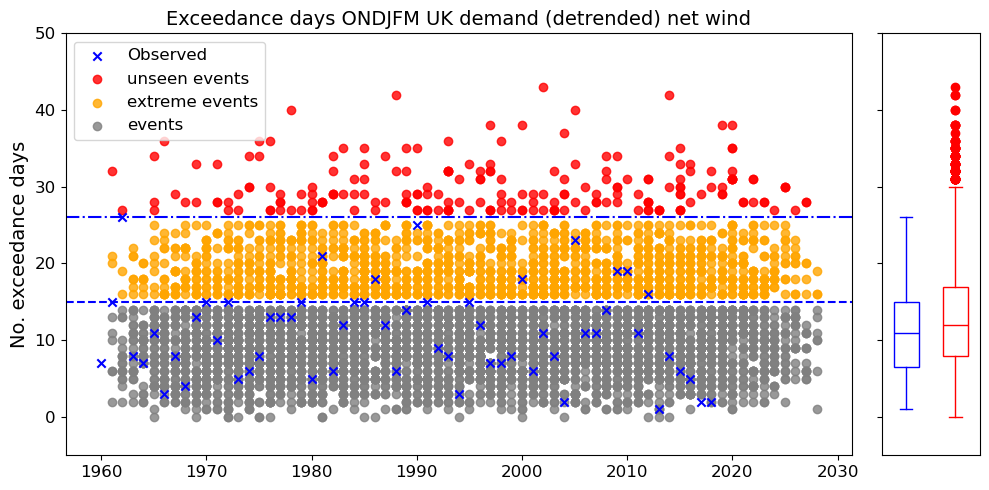

In [45]:
# plot the demand net wind exceedance days
dot_plot(
    obs_df=df_exceedance_days_obs,
    model_df=df_model_exceedance,
    obs_val_name="no_exceedance_days_demand_net_wind",
    model_val_name="no_exceedance_days_demand_net_wind",
    model_time_name="effective_dec_year",
    ylabel="No. exceedance days",
    title="Exceedance days ONDJFM UK demand (detrended) net wind",
    ylims=(-5, 50),
    dashed_quant=0.8,
    solid_line=np.max,
    figsize=(10, 5),
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
)

Bad events have high values
Saving plot to /gws/nopw/j04/canari/users/benhutch/plots/unseen/obs-no_undershoot_days_wind_model-no_undershoot_days_wind_quantile-0.8_solid-max_dot_plot_2024-12-18-14-26-01.pdf
Saved plot to /gws/nopw/j04/canari/users/benhutch/plots/unseen/obs-no_undershoot_days_wind_model-no_undershoot_days_wind_quantile-0.8_solid-max_dot_plot_2024-12-18-14-26-01.pdf


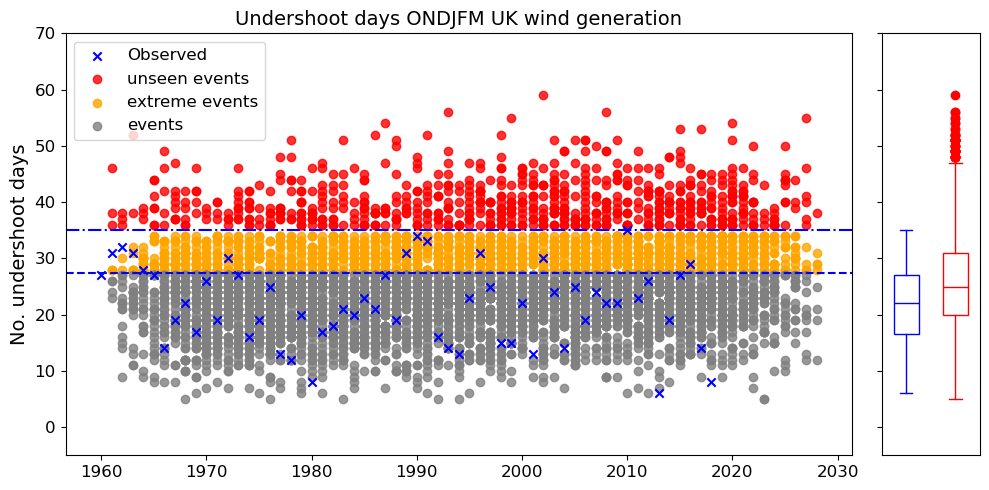

In [46]:
# Do the same but for wind power
dot_plot(
    obs_df=df_exceedance_days_obs,
    model_df=df_model_exceedance,
    obs_val_name="no_undershoot_days_wind",
    model_val_name="no_undershoot_days_wind",
    model_time_name="effective_dec_year",
    ylabel="No. undershoot days",
    title="Undershoot days ONDJFM UK wind generation",
    ylims=(-5, 70),
    dashed_quant=0.8,
    solid_line=np.max,
    figsize=(10, 5),
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
)

Bad events have high values
Saving plot to /gws/nopw/j04/canari/users/benhutch/plots/unseen/obs-no_exceedance_days_demand_model-no_exceedance_days_demand_quantile-0.8_solid-max_dot_plot_2024-12-18-14-26-02.pdf
Saved plot to /gws/nopw/j04/canari/users/benhutch/plots/unseen/obs-no_exceedance_days_demand_model-no_exceedance_days_demand_quantile-0.8_solid-max_dot_plot_2024-12-18-14-26-02.pdf


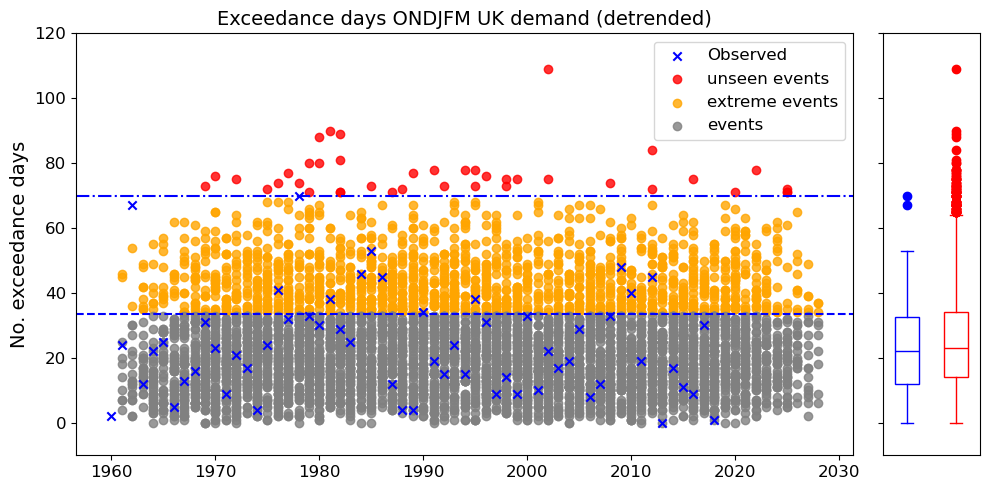

In [47]:
# Do the same but for detrended demand
dot_plot(
    obs_df=df_exceedance_days_obs,
    model_df=df_model_exceedance,
    obs_val_name="no_exceedance_days_demand",
    model_val_name="no_exceedance_days_demand",
    model_time_name="effective_dec_year",
    ylabel="No. exceedance days",
    title="Exceedance days ONDJFM UK demand (detrended)",
    ylims=(-10, 120),
    dashed_quant=0.8,
    solid_line=np.max,
    figsize=(10, 5),
    save_dir="/gws/nopw/j04/canari/users/benhutch/plots/unseen",
)

Now look at the return period for extremes.

In [48]:
# reset index of obs_df
df_exceedance_days_obs.reset_index(inplace=True)

In [49]:
df_exceedance_days_obs.head()

,index,severity_index_demand,no_exceedance_days_demand,severity_index_demand_net_wind,no_exceedance_days_demand_net_wind,severity_index_wind,no_undershoot_days_wind
0,1960,0.790387,2,8.833997,7,49.157260,27
1,1961,27.877418,24,26.456997,15,53.891523,31
2,1962,117.716482,67,67.184280,26,53.061683,32
3,1963,9.360300,12,8.456894,8,38.369448,31
4,1964,22.499508,22,9.901393,7,44.089426,28


In [50]:
# quantify the 99.9th percentile of the obs data for demand net wind
df_exceedance_days_obs["no_exceedance_days_demand_net_wind"].quantile(0.999)

np.float64(25.942000000000007)

In [51]:
np.max(df_exceedance_days_obs["no_exceedance_days_demand_net_wind"])

np.int64(26)

99.9th %tile ~ max(DnW exceedance days) ~ 26 days (1962/63 winter)

In [52]:
# # For demand net wind
# plot_rp_extremes(
#     obs_df=df_exceedance_days_obs,
#     model_df=df_model_exceedance,
#     obs_val_name="no_exceedance_days_demand_net_wind",
#     model_val_name="no_exceedance_days_demand_net_wind",
#     obs_time_name="index",
#     model_time_name="effective_dec_year",
#     ylim=(0, 50),
#     percentile=99.9,
# )

In [53]:
# print the 99.9th percentile of the model data
print(np.max(df_model_exceedance["no_undershoot_days_wind"]))
print(np.quantile(df_model_exceedance["no_undershoot_days_wind"], 0.999))

59.0
54.0


In [54]:
# # Same for wind
# plot_rp_extremes(
#     obs_df=df_exceedance_days_obs,
#     model_df=df_model_exceedance,
#     obs_val_name="no_undershoot_days_wind",
#     model_val_name="no_undershoot_days_wind",
#     obs_time_name="index",
#     model_time_name="effective_dec_year",
#     ylim=(0, 70),
#     percentile=99.9,
# )

In [55]:
# # same for demand
# plot_rp_extremes(
#     obs_df=df_exceedance_days_obs,
#     model_df=df_model_exceedance,
#     obs_val_name="no_exceedance_days_demand",
#     model_val_name="no_exceedance_days_demand",
#     obs_time_name="index",
#     model_time_name="effective_dec_year",
#     ylim=(0, 120),
#     percentile=99.9,
# )

In [56]:
importlib.reload(sys.modules["functions"])
from functions import plot_rp_extremes_decades

In [57]:
df_exceedance_days_obs.head()

,index,severity_index_demand,no_exceedance_days_demand,severity_index_demand_net_wind,no_exceedance_days_demand_net_wind,severity_index_wind,no_undershoot_days_wind
0,1960,0.790387,2,8.833997,7,49.157260,27
1,1961,27.877418,24,26.456997,15,53.891523,31
2,1962,117.716482,67,67.184280,26,53.061683,32
3,1963,9.360300,12,8.456894,8,38.369448,31
4,1964,22.499508,22,9.901393,7,44.089426,28


In [58]:
# set up the index column as the index
df_exceedance_days_obs.set_index("index", inplace=True)

In [59]:
# params, years = plot_rp_extremes_decades(
#     obs_df=df_exceedance_days_obs,
#     model_df=df_model_exceedance,
#     obs_val_name="no_exceedance_days_demand_net_wind",
#     model_val_name="no_exceedance_days_demand_net_wind",
#     obs_time_name="index",
#     model_time_name="effective_dec_year",
# )

In [60]:
# obs_df=df_exceedance_days_obs
# model_df=df_model_exceedance
# obs_val_name="no_exceedance_days_demand_net_wind"
# model_val_name="no_exceedance_days_demand_net_wind"
# worst_or_perc_rp="worst"
# percentile=99.9
# decades = np.arange(1960, 2030, 10)
# plot_rp_percentage=True
# years_period = (1960, 2028)
# save_prefix = "rp_extremes_decades"
# save_dir = "/gws/nopw/j04/canari/users/benhutch/plots"
# y_label = "No. exceedance days"

In [61]:
# # Set up the array for mean, 2.5th and 97.5th percentiles
# period_decade_mean = np.zeros([len(years)])
# period_decade_025 = np.zeros([len(years)])
# period_decade_975 = np.zeros([len(years)])

# if worst_or_perc_rp == "worst":
#     print("Calculating return period for worst (max) event")
#     obs_bad_event = obs_df[obs_val_name].max()
# elif worst_or_perc_rp == "perc":
#     print(f"Calculating return period for {percentile}th percentile event")
#     obs_bad_event = np.percentile(obs_df[obs_val_name], percentile)
# else:
#     raise ValueError("worst_or_perc_rp must be either 'worst' or 'perc'")

# # loop over the unique years to fit the ppfs
# for i, decade in tqdm(enumerate(years)):
#     # Subset the params for the decade
#     params_decade = params[i, :, :]

#     # Estimate the period for the model mean data
#     period_decade_mean[i] = estimate_period(
#         return_level=obs_bad_event,
#         loc=np.mean(params_decade[:, 1]),
#         scale=np.mean(params_decade[:, 2]),
#         shape=np.mean(params_decade[:, 0]),
#     )

#     # model 025 percentile
#     period_decade_025[i] = estimate_period(
#         return_level=obs_bad_event,
#         loc=np.percentile(params_decade[:, 1], 2.5),
#         scale=np.percentile(params_decade[:, 2], 2.5),
#         shape=np.percentile(params_decade[:, 0], 2.5),
#     )

#     # model 95 percentile
#     period_decade_975[i] = estimate_period(
#         return_level=obs_bad_event,
#         loc=np.percentile(params_decade[:, 1], 97.5),
#         scale=np.percentile(params_decade[:, 2], 97.5),
#         shape=np.percentile(params_decade[:, 0], 97.5),
#     )

# # put these into a dataframe with the years
# model_df_rl = pd.DataFrame(
#     {
#         "decade": decades,
#         "mean": period_decade_mean,
#         "025": period_decade_025,
#         "975": period_decade_975,
#     }
# )

# # for each row of "mean", "025", "975" calculate the return period
# # 1 / (1 - (100 - value))
# model_df_rl["mean_rp (%)"] = 1 - (model_df_rl["mean"] / 100)
# model_df_rl["025_rp (%)"] = 1 - (model_df_rl["025"] / 100)
# model_df_rl["975_rp (%)"] = 1 - (model_df_rl["975"] / 100)

# # calculate the return period in years of the observed worst event
# model_df_rl["mean_rp (years)"] = 1 / model_df_rl["mean_rp (%)"]
# model_df_rl["025_rp (years)"] = 1 / model_df_rl["025_rp (%)"]
# model_df_rl["975_rp (years)"] = 1 / model_df_rl["975_rp (%)"]

# # plot the mean rp values with error bars for the 025 and 975 percentiles
# plt.figure(figsize=(10, 5))

# # if we are plotting the return period as a percentage
# if plot_rp_percentage:
#     y_val_mean = model_df_rl["mean_rp (%)"]
#     y_val_025 = model_df_rl["025_rp (%)"]
#     y_val_975 = model_df_rl["975_rp (%)"]
#     y_label = "Return period (%)"

#     # Set up the error bars
#     upper_errs = abs(model_df_rl["025_rp (%)"] - model_df_rl["mean_rp (%)"])
#     lower_errs = abs(model_df_rl["mean_rp (%)"] - model_df_rl["975_rp (%)"])

#     # set up the yticks
#     yticks_ints = [0.01, 0.1]
#     yticks_strs = ["1%", "10%"]

# else:
#     y_val_mean = model_df_rl["mean_rp (years)"]
#     y_val_025 = model_df_rl["025_rp (years)"]
#     y_val_975 = model_df_rl["975_rp (years)"]
#     y_label = "Return period (years)"

#     # Set up the error bars
#     upper_errs = model_df_rl["975_rp (years)"] - model_df_rl["mean_rp (years)"]
#     lower_errs = model_df_rl["mean_rp (years)"] - model_df_rl["025_rp (years)"]

#     # set up the yticks
#     yticks_ints = [1, 10, 100, 1000]
#     yticks_strs = ["1", "10", "100", "1000"]

# # print the upper and lower errors
# print(f"Upper errors: {upper_errs}")
# print(f"Lower errors: {lower_errs}")

# # assert that upper errs and lower errors are positive
# assert np.all(upper_errs > 0), "Upper errors must be positive"
# assert np.all(lower_errs > 0), "Lower errors must be positive"

# # Plot the mean
# plt.scatter(
#     model_df_rl["decade"],
#     y_val_mean,
#     color="red",
# )

# # Plot the 025 and 975 percentiles
# plt.errorbar(
#     model_df_rl["decade"],
#     y_val_mean,
#     yerr=[lower_errs, upper_errs],
#     fmt="none",
#     color="red",
#     capsize=5,
# )

# # Set up the yscale
# plt.yscale("log")

# # Set up the yticks
# plt.yticks(yticks_ints, yticks_strs)

# # Set up the ylabel
# plt.ylabel(y_label, fontsize=12)

# # Set up the title
# if worst_or_perc_rp == "worst":
#     plt.title(f"RP of worst {obs_val_name} event {years_period[0]}-{years_period[1]}", fontsize=12)
# elif worst_or_perc_rp == "perc":
#     plt.title(f"RP of {percentile}th %tile {obs_val_name} event {years_period[0]}-{years_period[1]}", fontsize=12)
# else:
#     raise ValueError("worst_or_perc_rp must be either 'worst' or 'perc'")

# # Set up the fname
# fname = f"{save_prefix}_{datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}.pdf"

# # Set up the savepath
# savepath = os.path.join(save_dir, fname)

# # if the savepath does not exist
# if not os.path.exists(savepath):
#     print(f"Saving plot to {savepath}")

#     # Save the plot
#     plt.savefig(savepath, bbox_inches="tight", dpi=800)
# else:
#     print(f"Savepath {savepath} already exists")

In [62]:
# params, years = plot_rp_extremes_decades(
#     obs_df=df_exceedance_days_obs,
#     model_df=df_model_exceedance,
#     obs_val_name="no_exceedance_days_demand",
#     model_val_name="no_exceedance_days_demand",
#     obs_time_name="index",
#     model_time_name="effective_dec_year",
# )

In [63]:
# obs_val_name="no_exceedance_days_demand"
# model_val_name="no_exceedance_days_demand"

# obs_df=df_exceedance_days_obs
# model_df=df_model_exceedance
# worst_or_perc_rp="worst"
# percentile=99.9
# decades = np.arange(1960, 2030, 10)
# plot_rp_percentage=True
# years_period = (1960, 2028)
# save_prefix = "rp_extremes_decades"
# save_dir = "/gws/nopw/j04/canari/users/benhutch/plots"
# y_label = "No. exceedance days demand"

In [64]:
# # Set up the array for mean, 2.5th and 97.5th percentiles
# period_decade_mean = np.zeros([len(years)])
# period_decade_025 = np.zeros([len(years)])
# period_decade_975 = np.zeros([len(years)])

# if worst_or_perc_rp == "worst":
#     print("Calculating return period for worst (max) event")
#     obs_bad_event = obs_df[obs_val_name].max()
# elif worst_or_perc_rp == "perc":
#     print(f"Calculating return period for {percentile}th percentile event")
#     obs_bad_event = np.percentile(obs_df[obs_val_name], percentile)
# else:
#     raise ValueError("worst_or_perc_rp must be either 'worst' or 'perc'")

# # loop over the unique years to fit the ppfs
# for i, decade in tqdm(enumerate(years)):
#     # Subset the params for the decade
#     params_decade = params[i, :, :]

#     # Estimate the period for the model mean data
#     period_decade_mean[i] = estimate_period(
#         return_level=obs_bad_event,
#         loc=np.mean(params_decade[:, 1]),
#         scale=np.mean(params_decade[:, 2]),
#         shape=np.mean(params_decade[:, 0]),
#     )

#     # model 025 percentile
#     period_decade_025[i] = estimate_period(
#         return_level=obs_bad_event,
#         loc=np.percentile(params_decade[:, 1], 2.5),
#         scale=np.percentile(params_decade[:, 2], 2.5),
#         shape=np.percentile(params_decade[:, 0], 2.5),
#     )

#     # model 95 percentile
#     period_decade_975[i] = estimate_period(
#         return_level=obs_bad_event,
#         loc=np.percentile(params_decade[:, 1], 97.5),
#         scale=np.percentile(params_decade[:, 2], 97.5),
#         shape=np.percentile(params_decade[:, 0], 97.5),
#     )

# # put these into a dataframe with the years
# model_df_rl = pd.DataFrame(
#     {
#         "decade": decades,
#         "mean": period_decade_mean,
#         "025": period_decade_025,
#         "975": period_decade_975,
#     }
# )

# # for each row of "mean", "025", "975" calculate the return period
# # 1 / (1 - (100 - value))
# model_df_rl["mean_rp (%)"] = 1 - (model_df_rl["mean"] / 100)
# model_df_rl["025_rp (%)"] = 1 - (model_df_rl["025"] / 100)
# model_df_rl["975_rp (%)"] = 1 - (model_df_rl["975"] / 100)

# # calculate the return period in years of the observed worst event
# model_df_rl["mean_rp (years)"] = 1 / model_df_rl["mean_rp (%)"]
# model_df_rl["025_rp (years)"] = 1 / model_df_rl["025_rp (%)"]
# model_df_rl["975_rp (years)"] = 1 / model_df_rl["975_rp (%)"]

# # plot the mean rp values with error bars for the 025 and 975 percentiles
# plt.figure(figsize=(10, 5))

# # if we are plotting the return period as a percentage
# if plot_rp_percentage:
#     y_val_mean = model_df_rl["mean_rp (%)"]
#     y_val_025 = model_df_rl["025_rp (%)"]
#     y_val_975 = model_df_rl["975_rp (%)"]
#     y_label = "Return period (%)"

#     # Set up the error bars
#     upper_errs = (model_df_rl["025_rp (%)"] - model_df_rl["mean_rp (%)"])
#     lower_errs = (model_df_rl["mean_rp (%)"] - model_df_rl["975_rp (%)"])

#     # set up the yticks
#     yticks_ints = [0.001, 0.01, 0.1]
#     yticks_strs = ["0.1%", "1%", "10%"]

# else:
#     y_val_mean = model_df_rl["mean_rp (years)"]
#     y_val_025 = model_df_rl["025_rp (years)"]
#     y_val_975 = model_df_rl["975_rp (years)"]
#     y_label = "Return period (years)"

#     # Set up the error bars
#     upper_errs = model_df_rl["975_rp (years)"] - model_df_rl["mean_rp (years)"]
#     lower_errs = model_df_rl["mean_rp (years)"] - model_df_rl["025_rp (years)"]

#     # set up the yticks
#     yticks_ints = [1, 10, 100, 1000]
#     yticks_strs = ["1", "10", "100", "1000"]

# # print the upper and lower errors
# print(f"Upper errors: {upper_errs}")
# print(f"Lower errors: {lower_errs}")

# # assert that upper errs and lower errors are positive
# assert np.all(upper_errs > 0), "Upper errors must be positive"
# assert np.all(lower_errs > 0), "Lower errors must be positive"

# # Plot the mean
# plt.scatter(
#     model_df_rl["decade"],
#     y_val_mean,
#     color="red",
# )

# # Plot the 025 and 975 percentiles
# plt.errorbar(
#     model_df_rl["decade"],
#     y_val_mean,
#     yerr=[lower_errs, upper_errs],
#     fmt="none",
#     color="red",
#     capsize=5,
# )

# # Set up the yscale
# plt.yscale("log")

# # Set up the yticks
# plt.yticks(yticks_ints, yticks_strs)

# # Set up the ylabel
# plt.ylabel(y_label, fontsize=12)

# # Set up the title
# if worst_or_perc_rp == "worst":
#     plt.title(f"RP of worst {obs_val_name} event {years_period[0]}-{years_period[1]}", fontsize=12)
# elif worst_or_perc_rp == "perc":
#     plt.title(f"RP of {percentile}th %tile {obs_val_name} event {years_period[0]}-{years_period[1]}", fontsize=12)
# else:
#     raise ValueError("worst_or_perc_rp must be either 'worst' or 'perc'")

# # Set up the fname
# fname = f"{save_prefix}_{datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}.pdf"

# # Set up the savepath
# savepath = os.path.join(save_dir, fname)

# # if the savepath does not exist
# if not os.path.exists(savepath):
#     print(f"Saving plot to {savepath}")

#     # Save the plot
#     plt.savefig(savepath, bbox_inches="tight", dpi=800)
# else:
#     print(f"Savepath {savepath} already exists")

In [65]:
# params, years = plot_rp_extremes_decades(
#     obs_df=df_exceedance_days_obs,
#     model_df=df_model_exceedance,
#     obs_val_name="no_undershoot_days_wind",
#     model_val_name="no_undershoot_days_wind",
#     obs_time_name="index",
#     model_time_name="effective_dec_year",
# )

In [66]:
# obs_val_name="no_undershoot_days_wind"
# model_val_name="no_undershoot_days_wind"

# obs_df=df_exceedance_days_obs
# model_df=df_model_exceedance
# worst_or_perc_rp="worst"
# percentile=99.9
# decades = np.arange(1960, 2030, 10)
# plot_rp_percentage=True
# years_period = (1960, 2028)
# save_prefix = "rp_extremes_decades"
# save_dir = "/gws/nopw/j04/canari/users/benhutch/plots"
# y_label = "No. exceedance days wind"

In [67]:
# # Set up the array for mean, 2.5th and 97.5th percentiles
# period_decade_mean = np.zeros([len(years)])
# period_decade_025 = np.zeros([len(years)])
# period_decade_975 = np.zeros([len(years)])

# if worst_or_perc_rp == "worst":
#     print("Calculating return period for worst (max) event")
#     obs_bad_event = obs_df[obs_val_name].max()
# elif worst_or_perc_rp == "perc":
#     print(f"Calculating return period for {percentile}th percentile event")
#     obs_bad_event = np.percentile(obs_df[obs_val_name], percentile)
# else:
#     raise ValueError("worst_or_perc_rp must be either 'worst' or 'perc'")

# # loop over the unique years to fit the ppfs
# for i, decade in tqdm(enumerate(years)):
#     # Subset the params for the decade
#     params_decade = params[i, :, :]

#     # Estimate the period for the model mean data
#     period_decade_mean[i] = estimate_period(
#         return_level=obs_bad_event,
#         loc=np.mean(params_decade[:, 1]),
#         scale=np.mean(params_decade[:, 2]),
#         shape=np.mean(params_decade[:, 0]),
#     )

#     # model 025 percentile
#     period_decade_025[i] = estimate_period(
#         return_level=obs_bad_event,
#         loc=np.percentile(params_decade[:, 1], 2.5),
#         scale=np.percentile(params_decade[:, 2], 2.5),
#         shape=np.percentile(params_decade[:, 0], 2.5),
#     )

#     # model 95 percentile
#     period_decade_975[i] = estimate_period(
#         return_level=obs_bad_event,
#         loc=np.percentile(params_decade[:, 1], 97.5),
#         scale=np.percentile(params_decade[:, 2], 97.5),
#         shape=np.percentile(params_decade[:, 0], 97.5),
#     )

# # put these into a dataframe with the years
# model_df_rl = pd.DataFrame(
#     {
#         "decade": decades,
#         "mean": period_decade_mean,
#         "025": period_decade_025,
#         "975": period_decade_975,
#     }
# )

# # for each row of "mean", "025", "975" calculate the return period
# # 1 / (1 - (100 - value))
# model_df_rl["mean_rp (%)"] = 1 - (model_df_rl["mean"] / 100)
# model_df_rl["025_rp (%)"] = 1 - (model_df_rl["025"] / 100)
# model_df_rl["975_rp (%)"] = 1 - (model_df_rl["975"] / 100)

# # calculate the return period in years of the observed worst event
# model_df_rl["mean_rp (years)"] = 1 / model_df_rl["mean_rp (%)"]
# model_df_rl["025_rp (years)"] = 1 / model_df_rl["025_rp (%)"]
# model_df_rl["975_rp (years)"] = 1 / model_df_rl["975_rp (%)"]

# # plot the mean rp values with error bars for the 025 and 975 percentiles
# plt.figure(figsize=(10, 5))

# # if we are plotting the return period as a percentage
# if plot_rp_percentage:
#     y_val_mean = model_df_rl["mean_rp (%)"]
#     y_val_025 = model_df_rl["025_rp (%)"]
#     y_val_975 = model_df_rl["975_rp (%)"]
#     y_label = "Return period (%)"

#     # Set up the error bars
#     # upper_errs = (model_df_rl["025_rp (%)"] - model_df_rl["mean_rp (%)"])
#     # lower_errs = (model_df_rl["mean_rp (%)"] - model_df_rl["975_rp (%)"])
#     upper_errs = model_df_rl["975_rp (%)"] - model_df_rl["mean_rp (%)"]
#     lower_errs = model_df_rl["mean_rp (%)"] - model_df_rl["025_rp (%)"]

#     # set up the yticks
#     yticks_ints = [0.001, 0.01, 0.1]
#     yticks_strs = ["0.1%", "1%", "10%"]

# else:
#     y_val_mean = model_df_rl["mean_rp (years)"]
#     y_val_025 = model_df_rl["025_rp (years)"]
#     y_val_975 = model_df_rl["975_rp (years)"]
#     y_label = "Return period (years)"

#     # Set up the error bars
#     upper_errs = model_df_rl["975_rp (years)"] - model_df_rl["mean_rp (years)"]
#     lower_errs = model_df_rl["mean_rp (years)"] - model_df_rl["025_rp (years)"]

#     # set up the yticks
#     yticks_ints = [1, 10, 100, 1000]
#     yticks_strs = ["1", "10", "100", "1000"]

# # print the upper and lower errors
# print(f"Upper errors: {upper_errs}")
# print(f"Lower errors: {lower_errs}")

# # assert that upper errs and lower errors are positive
# assert np.all(upper_errs > 0), "Upper errors must be positive"
# assert np.all(lower_errs > 0), "Lower errors must be positive"

# # Plot the mean
# plt.scatter(
#     model_df_rl["decade"],
#     y_val_mean,
#     color="red",
# )

# # Plot the 025 and 975 percentiles
# plt.errorbar(
#     model_df_rl["decade"],
#     y_val_mean,
#     yerr=[lower_errs, upper_errs],
#     fmt="none",
#     color="red",
#     capsize=5,
# )

# # Set up the yscale
# plt.yscale("log")

# # Set up the yticks
# plt.yticks(yticks_ints, yticks_strs)

# # Set up the ylabel
# plt.ylabel(y_label, fontsize=12)

# # Set up the title
# if worst_or_perc_rp == "worst":
#     plt.title(f"RP of worst {obs_val_name} event {years_period[0]}-{years_period[1]}", fontsize=12)
# elif worst_or_perc_rp == "perc":
#     plt.title(f"RP of {percentile}th %tile {obs_val_name} event {years_period[0]}-{years_period[1]}", fontsize=12)
# else:
#     raise ValueError("worst_or_perc_rp must be either 'worst' or 'perc'")

# # Set up the fname
# fname = f"{save_prefix}_{datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}.pdf"

# # Set up the savepath
# savepath = os.path.join(save_dir, fname)

# # if the savepath does not exist
# if not os.path.exists(savepath):
#     print(f"Saving plot to {savepath}")

#     # Save the plot
#     plt.savefig(savepath, bbox_inches="tight", dpi=800)
# else:
#     print(f"Savepath {savepath} already exists")

Now move onto looking at the drivers.

In [87]:
importlib.reload(sys.modules["functions"])
from functions import plot_composite_obs_model_exceed

In [88]:
composite, years, members, leads, lats, lons, exceed_dict = plot_composite_obs_model_exceed(
    model_df=df_model_exceedance,
    model_val_name="no_exceedance_days_demand_net_wind",
    exceedance_days=[35, 38, 40],  # short for testing purposes
    calc_anoms=True,
)

Threshold: 35
Threshold: 38
Threshold: 40
Loading the file from /gws/nopw/j04/canari/users/benhutch/saved_DePre/HadGEM3-GC31-MM/psl/Amon/ONDJFM/1960-2018/HadGEM3-GC31-MM_psl_ONDJFM_Amon_1960-2018.npy
Time taken to load the file: 7.53 seconds
Shape of the composite: (59, 10, 125, 324, 432)
values of the composite: [[100048.56  100049.31  100050.06  ... 100046.5   100047.19  100047.875]
 [100081.875 100083.56  100085.19  ... 100076.75  100078.44  100080.19 ]
 [100053.25  100055.125 100057.19  ... 100048.44  100049.94  100051.5  ]
 ...
 [102404.06  102403.94  102403.81  ... 102404.75  102404.5   102404.31 ]
 [102483.375 102483.375 102483.375 ... 102483.56  102483.5   102483.44 ]
 [102562.    102562.    102562.06  ... 102562.06  102562.    102562.   ]]


In [90]:
composite

array([[[[[100048.56 , 100049.31 , 100050.06 , ..., 100046.5  ,
           100047.19 , 100047.875],
          [100081.875, 100083.56 , 100085.19 , ..., 100076.75 ,
           100078.44 , 100080.19 ],
          [100053.25 , 100055.125, 100057.19 , ..., 100048.44 ,
           100049.94 , 100051.5  ],
          ...,
          [102404.06 , 102403.94 , 102403.81 , ..., 102404.75 ,
           102404.5  , 102404.31 ],
          [102483.375, 102483.375, 102483.375, ..., 102483.56 ,
           102483.5  , 102483.44 ],
          [102562.   , 102562.   , 102562.06 , ..., 102562.06 ,
           102562.   , 102562.   ]],

         [[101355.5  , 101355.94 , 101356.25 , ..., 101354.5  ,
           101354.69 , 101355.125],
          [101330.375, 101331.25 , 101332.56 , ..., 101327.125,
           101328.25 , 101329.31 ],
          [101298.56 , 101299.81 , 101301.56 , ..., 101294.19 ,
           101295.75 , 101297.125],
          ...,
          [101107.06 , 101106.75 , 101106.5  , ..., 101108.125,
    

In [94]:
exceed_dict[35]

[(1965, 10, 3),
 (1965, 1, 5),
 (1968, 8, 6),
 (1971, 7, 1),
 (1981, 7, 4),
 (1985, 8, 1),
 (1990, 8, 9),
 (1990, 10, 9),
 (1992, 5, 9),
 (1992, 10, 9),
 (1995, 9, 5),
 (2001, 4, 4),
 (2013, 1, 2),
 (2013, 6, 9),
 (2014, 6, 5)]

In [95]:
years

array([1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018])

In [96]:
leads

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125])

In [97]:
composite.shape

(59, 10, 125, 324, 432)

In [106]:
# Set up composite winter years
winter_years = np.arange(1, 10 + 1, 1)

# Set up the composite array
composite_array = np.zeros([len(years), len(members), len(winter_years), len(lats), len(lons)])

# print the shape of the composite array
print(composite_array.shape)

# Loop over the winter years
for i, wyear in enumerate(winter_years):
    # Set up the lead values to extract
    leads_values_this = np.arange((wyear * 12), (wyear * 12) + 6, 1)

    # Find the index of the lead values in leads
    idx = np.where(np.isin(leads, leads_values_this))[0]

    # Extract the values and take the mean along axis 2
    composite_mean = np.mean(composite[:, :, idx, :, :], axis=2)

    # Assign the mean values to the composite array
    composite_array[:, :, i, :, :] = composite_mean

(59, 10, 10, 324, 432)
[12 13 14 15 16 17]
[11 12 13 14 15 16]
(59, 10, 6, 324, 432)
(59, 10, 324, 432)
(59, 10, 324, 432)
[24 25 26 27 28 29]
[23 24 25 26 27 28]
(59, 10, 6, 324, 432)
(59, 10, 324, 432)
(59, 10, 324, 432)
[36 37 38 39 40 41]
[35 36 37 38 39 40]
(59, 10, 6, 324, 432)
(59, 10, 324, 432)
(59, 10, 324, 432)
[48 49 50 51 52 53]
[47 48 49 50 51 52]
(59, 10, 6, 324, 432)
(59, 10, 324, 432)
(59, 10, 324, 432)
[60 61 62 63 64 65]
[59 60 61 62 63 64]
(59, 10, 6, 324, 432)
(59, 10, 324, 432)
(59, 10, 324, 432)
[72 73 74 75 76 77]
[71 72 73 74 75 76]
(59, 10, 6, 324, 432)
(59, 10, 324, 432)
(59, 10, 324, 432)
[84 85 86 87 88 89]
[83 84 85 86 87 88]
(59, 10, 6, 324, 432)
(59, 10, 324, 432)
(59, 10, 324, 432)
[ 96  97  98  99 100 101]
[ 95  96  97  98  99 100]
(59, 10, 6, 324, 432)
(59, 10, 324, 432)
(59, 10, 324, 432)
[108 109 110 111 112 113]
[107 108 109 110 111 112]
(59, 10, 6, 324, 432)
(59, 10, 324, 432)
(59, 10, 324, 432)
[120 121 122 123 124 125]
[119 120 121 122 123 124]
(

In [108]:
composite_array.shape

(59, 10, 10, 324, 432)

In [111]:
# Set up a dictionary to store the arrsy
composite_dict = {}

# Loop over the thresholds in exceedance dict
for thresh in exceed_dict:
    # print the len of the exceed dict
    print(len(exceed_dict[thresh]))

    # Set up the composite array
    composite_array_thresh_this = np.zeros(
        [len(exceed_dict[thresh]), len(lats), len(lons)]
    )

    # Loop over the init_years, winter_year, members
    for i, (init_year, winter_year, member) in tqdm(enumerate(exceed_dict[thresh])):
        # Print the init year, winter year and member
        # print(f"init_year: {init_year}, winter_year: {winter_year}, member: {member}")

        # Find the index of the init year in years
        idx_year_this = np.where(years == init_year)[0][0]

        # Find the index of the member in members
        idx_member_this = np.where(members == member)[0][0]

        # Find the index of the winter year in winter years
        idx_winter_this = np.where(winter_years == winter_year)[0][0]

        # print the idx year, member and winter
        # print(f"idx_year: {idx_year_this}, idx_member: {idx_member_this}, idx_winter: {idx_winter_this}")

        # Assign the values to the composite array
        composite_array_thresh_this[i, :, :] = composite_array[
            idx_year_this, idx_member_this, idx_winter_this, :, :
        ]

    # Assign the composite array to the dictionary
    composite_dict[thresh] = composite_array_thresh_this

15


15it [00:00, 4260.48it/s]


5


5it [00:00, 8169.66it/s]


3


3it [00:00, 12905.55it/s]


In [116]:
composite_dict[40].shape

(3, 324, 432)

Now calculate a 30 year climatology to remove

E.g. 1990-2018, all members, all winter years

In [118]:
# Set up the years for the climatology
years_clim = np.arange(1990, 2018 + 1, 1)

# Find the index of the years in the years array
idx_years_clim = np.where(np.isin(years, years_clim))[0]

# Extract the values from the composite array
composite_clim = np.mean(composite_array[idx_years_clim, :, :, :, :], axis=(0, 1, 2))

Now do the bootstrapping

In [120]:
# Reshape data to be 3d
# Multiply init years * members * winter years
reshaped_composite_arr = composite_array.reshape(
    composite_array.shape[0] * composite_array.shape[1] * composite_array.shape[2],
    composite_array.shape[3],
    composite_array.shape[4],
)

In [122]:
reshaped_composite_arr[0]

array([[100196.5078125, 100197.1875   , 100197.84375  , ...,
        100194.59375  , 100195.2265625, 100195.8515625],
       [100208.53125  , 100209.9921875, 100211.3828125, ...,
        100204.1484375, 100205.6015625, 100207.0625   ],
       [100180.8359375, 100182.8515625, 100185.09375  , ...,
        100176.28125  , 100177.6171875, 100179.0859375],
       ...,
       [102116.6484375, 102117.2265625, 102117.84375  , ...,
        102114.9609375, 102115.4921875, 102116.0625   ],
       [102154.5625   , 102154.9296875, 102155.3046875, ...,
        102153.5390625, 102153.8671875, 102154.2109375],
       [102193.6171875, 102193.71875  , 102193.8671875, ...,
        102193.2578125, 102193.375    , 102193.5      ]])

In [123]:
# Set up a dictionary for compoosite anomalies
composite_anoms_dict = {}

# Qunatify both as anomalies
for thresh in composite_dict:
    composite_array_this = composite_dict[thresh]

    # Take the mean over the first dimension
    composite_anoms_this = np.mean(composite_array_this, axis=0) - composite_clim

    # Assign to the dictionary
    composite_anoms_dict[thresh] = composite_anoms_this

# Quantify the composite anomalies
reshaped_composite_arr_anoms = reshaped_composite_arr - composite_clim

In [133]:
reshaped_composite_arr_anoms.shape

(5900, 324, 432)

In [131]:
composite_anoms_dict[40].shape

(324, 432)

In [128]:
# Divide both by 100 to get in hPa
for thresh in composite_anoms_dict:
    composite_anoms_dict[thresh] = composite_anoms_dict[thresh] / 100

# Divide reshaped composite array by 100
reshaped_composite_arr_anoms = reshaped_composite_arr_anoms / 100

In [135]:
import random

# Set up the nboot
nboot = 1000

# Set up the index for the model data to be bootstrapped
index_ens = range(reshaped_composite_arr_anoms.shape[0])

# Set up an empty dict for the composite means
composite_means_dict = {}

for thresh in composite_dict:
    print(f"Processing threshold {thresh}")
    
    # Find the n events
    n_events_this = composite_dict[thresh].shape[0]

    # Set up an empty array for the bootstrapped means
    composite_means_this = np.zeros([nboot, composite_dict[thresh].shape[1], composite_dict[thresh].shape[2]])

    # Loop over the nboot
    for iboot in tqdm(range(nboot)):
        # Set up the random indices
        ind_ens_this = np.array([random.choice(index_ens) for i in range(n_events_this)])

        # Take the mean over the random indices
        composite_means_this[iboot, :, :] = np.mean(reshaped_composite_arr_anoms[ind_ens_this, :, :], axis=0)

    # Assign to the dictionary
    composite_means_dict[thresh] = composite_means_this

Processing threshold 35


100%|██████████| 1000/1000 [00:01<00:00, 593.12it/s]


Processing threshold 38


100%|██████████| 1000/1000 [00:00<00:00, 1869.80it/s]


Processing threshold 40


100%|██████████| 1000/1000 [00:00<00:00, 2563.97it/s]


In [136]:
composite_means_dict[40].shape

(1000, 324, 432)

Now process the p values from this

E.g. value of 1 if the event mean lies outside of the 2.5th or 97.5th percentile.

value of 0 is the event means lies between the 2.5th and 97.5th percentile.

In [140]:
# Set up a p value dict
p_value_dict = {}

# Loop over the thresholds
for thresh in composite_means_dict:
    print(f"Processing threshold {thresh}")

    # Set up the composite means
    composite_means_this = composite_means_dict[thresh]

    # Set up the composite anomalies
    composite_anoms_this = composite_anoms_dict[thresh]

    # Set up the p values
    p_values_this = np.zeros([composite_means_this.shape[1], composite_means_this.shape[2]])

    # Loop over the lats
    for ilat in tqdm(range(composite_means_this.shape[1])):
        # Loop over the lons
        for ilon in range(composite_means_this.shape[2]):
            # Calculate the 2.5th and 97.5th percentiles
            lower_025 = np.percentile(composite_means_this[:, ilat, ilon], 2.5)
            higher_975 = np.percentile(composite_means_this[:, ilat, ilon], 97.5)

            # E.g. value of 1 if the event mean lies outside of the 2.5th or 97.5th percentile.
            # value of 0 is the event means lies between the 2.5th and 97.5th percentile.
            if composite_anoms_this[ilat, ilon] < lower_025 or composite_anoms_this[ilat, ilon] > higher_975:
                p_values_this[ilat, ilon] += 1
            else:
                p_values_this[ilat, ilon] += 0

    # Assign to the p value dict
    p_value_dict[thresh] = p_values_this

Processing threshold 35


100%|██████████| 324/324 [00:16<00:00, 20.06it/s]


Processing threshold 38


100%|██████████| 324/324 [00:16<00:00, 19.90it/s]


Processing threshold 40


100%|██████████| 324/324 [00:16<00:00, 20.20it/s]


In [142]:
# loop over the thresholds and print the sum of the p values
for thresh in p_value_dict:
    print(f"Threshold {thresh}")
    print(np.sum(p_value_dict[thresh]))

Threshold 35
31129.0
Threshold 38
23016.0
Threshold 40
19768.0


In [145]:
# print the lons
# convert the lons from 0-360 to -180 to 180
lons_conv = np.where(lons > 180, lons - 360, lons)

In [150]:
lons_conv.max()

np.float64(179.5833282470703)

In [151]:
# All imports for plotting
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from matplotlib import colors
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mplticker
from matplotlib.ticker import FuncFormatter
import matplotlib.gridspec as gridspec

importlib.reload(sys.modules["functions"])
from functions import format_func, format_func_one_decimal

In [155]:
test = composite_anoms_dict[40]

In [156]:
test

(324, 432)

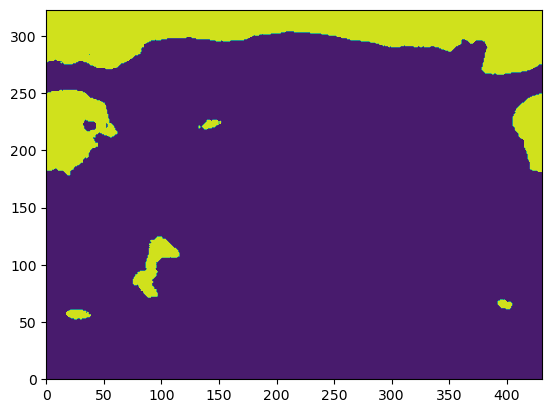

In [175]:
plt.contourf(p_value_dict[40])

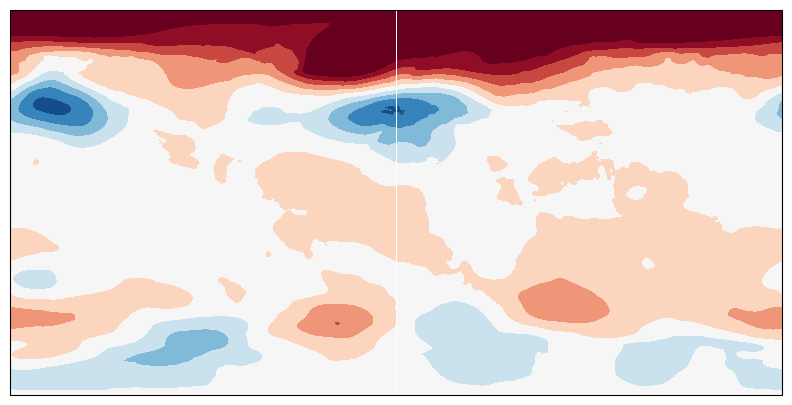

In [169]:
# make a simmple plot with test
fig, ax = plt.subplots(
    figsize=(10, 5),
    subplot_kw=dict(projection=ccrs.PlateCarree()),
)

# Set up the contour levels
clevs = np.arange(-5, 5, 1)

# Set up the contourf
cf = ax.contourf(
    lons,
    lats,
    test,
    levels=clevs,
    cmap="RdBu_r",
    extend="both",
    transform=ccrs.PlateCarree(),
)

[[0.17307524 0.17288227 0.17277    ... 0.17332375 0.17314577 0.17320318]
 [0.14255678 0.14223383 0.14189258 ... 0.14358063 0.14332024 0.1429448 ]
 [0.14593378 0.14557189 0.14522179 ... 0.14728056 0.14681289 0.14639627]
 ...
 [2.87178173 2.87078598 2.86977141 ... 2.87449887 2.87362808 2.87268619]
 [2.79723148 2.79654444 2.79587301 ... 2.79908746 2.79848686 2.79781898]
 [2.72593388 2.72570765 2.72544746 ... 2.726624   2.7264087  2.72616844]]
[[-0.30134663 -0.30169585 -0.30182896 ... -0.30090541 -0.3012136
  -0.3012187 ]
 [-0.30146926 -0.30246409 -0.30333658 ... -0.29918499 -0.29980997
  -0.30058645]
 [-0.28115997 -0.28226665 -0.28321571 ... -0.2779434  -0.2791142
  -0.28012977]
 ...
 [ 4.90776611  4.91127557  4.91460474 ...  4.89768637  4.90102912
   4.90433723]
 [ 4.95134607  4.95317465  4.95499801 ...  4.94599892  4.9477004
   4.94946482]
 [ 4.99281409  4.99331703  4.99385892 ...  4.99123338  4.99176808
   4.99229865]]
[[-0.82299767 -0.82309168 -0.82300604 ... -0.82291062 -0.82297923
 

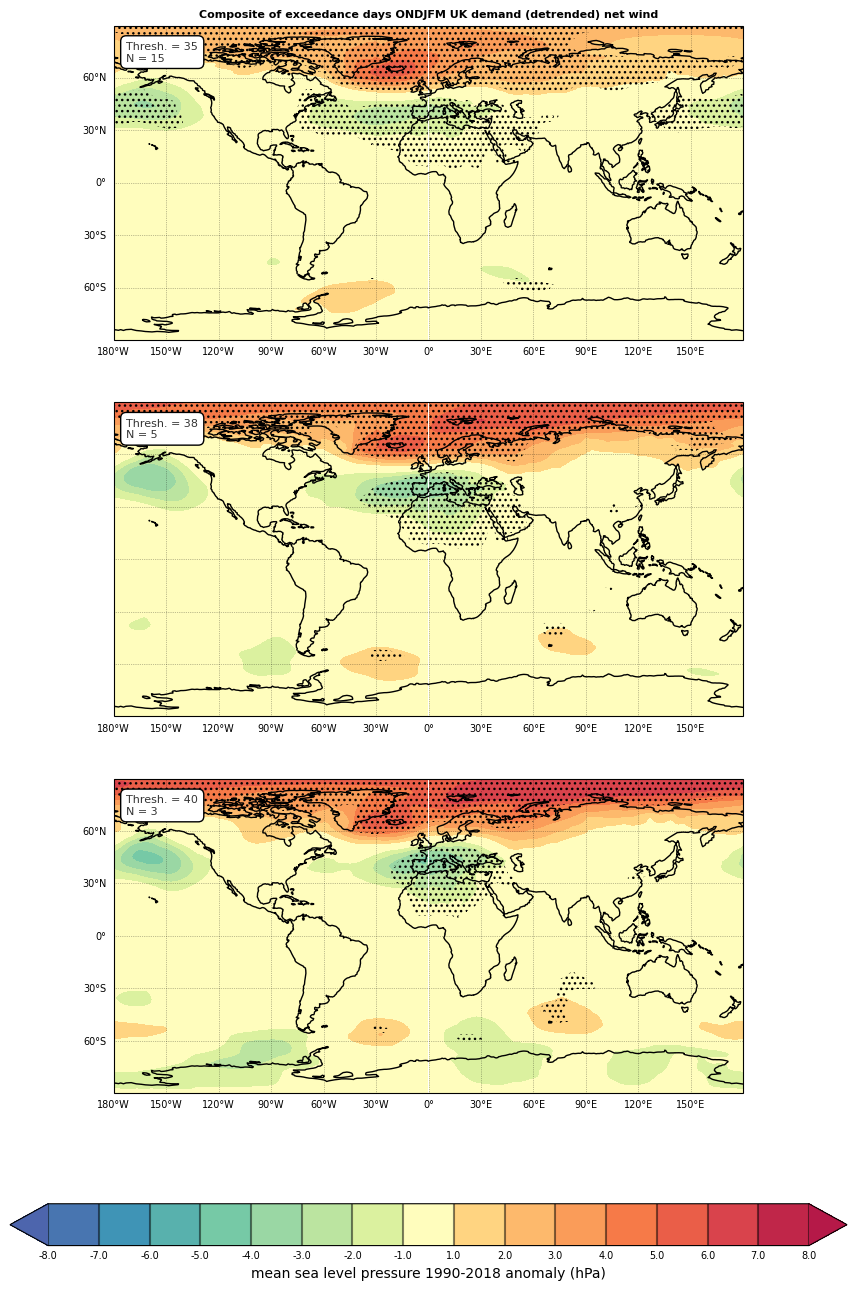

In [176]:
# # N events from tqdm above
n_events_list = [15, 5, 3]

# hard code the climatology period
climatology_period = (1990, 2018)

# Set up the figure as 3 rows and 1 column
fig, axs = plt.subplots(
    3, 1, figsize=(12, 18), subplot_kw={"projection": ccrs.PlateCarree()}
)

# Assuming we are plotting anoms
clevs = np.array(
    [
        -8.0,
        -7.0,
        -6.0,
        -5.0,
        -4.0,
        -3.0,
        -2.0,
        -1.0,
        1.0,
        2.0,
        3.0,
        4.0,
        5.0,
        6.0,
        7.0,
        8.0,
    ]
)
ticks = clevs

# ensure that these are floats
clevs = clevs.astype(float)
ticks = ticks.astype(float)

# custom colormap
cs = [
    "#4D65AD",
    "#3E97B7",
    "#6BC4A6",
    "#A4DBA4",
    "#D8F09C",
    "#FFFEBE",
    "#FFD27F",
    "#FCA85F",
    "#F57244",
    "#DD484C",
    "#B51948",
]

cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", cs)

# loop over the fields
for i, thresh in enumerate(composite_anoms_dict.keys()):
    
    # Extract the field for this
    field_this = composite_anoms_dict[thresh]

    # print the field this
    print(field_this)

    mymap = axs[i].contourf(
        lons,
        lats,
        field_this,
        clevs,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        extend="both",
    )

    # # contour lines
    # contours = axs[i].contour(
    #     lons,
    #     lats,
    #     field_this,
    #     clevs,
    #     colors="black",
    #     transform=ccrs.PlateCarree(),
    #     linewidth=0.2,
    #     alpha=0.5,
    # )

    # Set the labels for the contours
    axs[i].clabel(
        contours,
        clevs,
        fmt="%.4g",
        fontsize=8,
        inline=True,
        inline_spacing=0.0,
    )

for i, ax in enumerate(axs):
    # Set up the number of events
    num_event = n_events_list[i]

    # Set up the threshold
    thresh = list(composite_anoms_dict.keys())[i]

    # add coastlines
    ax.coastlines()

    # format the gridlines and labels
    gl = ax.gridlines(
        draw_labels=True, linewidth=0.5, color="black", alpha=0.5, linestyle=":"
    )
    gl.xlabels_top = False
    gl.xlocator = mplticker.FixedLocator(np.arange(-180, 180, 30))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.xlabel_style = {"size": 7, "color": "black"}
    gl.ylabels_right = False
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylabel_style = {"size": 7, "color": "black"}

    # get rid of the top labels
    gl.top_labels = False

    # get rid of the right labels
    gl.right_labels = False

    # if the iteration is 1
    if i == 1:
        gl.left_labels = False

    # include a textbox in the top left
    ax.text(
        0.02,
        0.95,
        f"""Thresh. = {thresh}\nN = {num_event}""",
        verticalalignment="top",
        horizontalalignment="left",
        transform=ax.transAxes,
        color="black",
        fontsize=8,
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"),
        alpha=0.8,
    )

    # ===================================
    # TODO: add significance p-field here
    # ===================================

    # Extract the pfield for this
    pfield_this = p_value_dict[thresh]

    # Where pfield_this is zero, set to nan
    pfield_this = np.where(pfield_this == 0, np.nan, pfield_this)

    # # plot the pfield
    axs[i].contourf(
        lons,
        lats,
        pfield_this,
        transform=ccrs.PlateCarree(),
        hatches=["..."],
        alpha=0.0,
    )


# Set up the colorbar
cbar = fig.colorbar(
    mymap,
    ax=axs,
    orientation="horizontal",
    shrink=0.9,
    pad=0.08,
    format=FuncFormatter(format_func_one_decimal),
)
# add colorbar label
cbar.set_label(
    f"mean sea level pressure {climatology_period[0]}-{climatology_period[1]} anomaly (hPa)",
    rotation=0,
    fontsize=10,
)

# add contour lines to the colorbar
cbar.add_lines(contours)

# Set up the title
axs[0].set_title(
    "Composite of exceedance days ONDJFM UK demand (detrended) net wind",
    fontsize=8,
    fontweight="bold",
)

cbar.ax.tick_params(labelsize=7, length=0)
cbar.set_ticks(ticks)

In [137]:
# All imports for plotting
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from matplotlib import colors
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mplticker
from matplotlib.ticker import FuncFormatter
import matplotlib.gridspec as gridspec

importlib.reload(sys.modules["functions"])
from functions import format_func, format_func_one_decimal

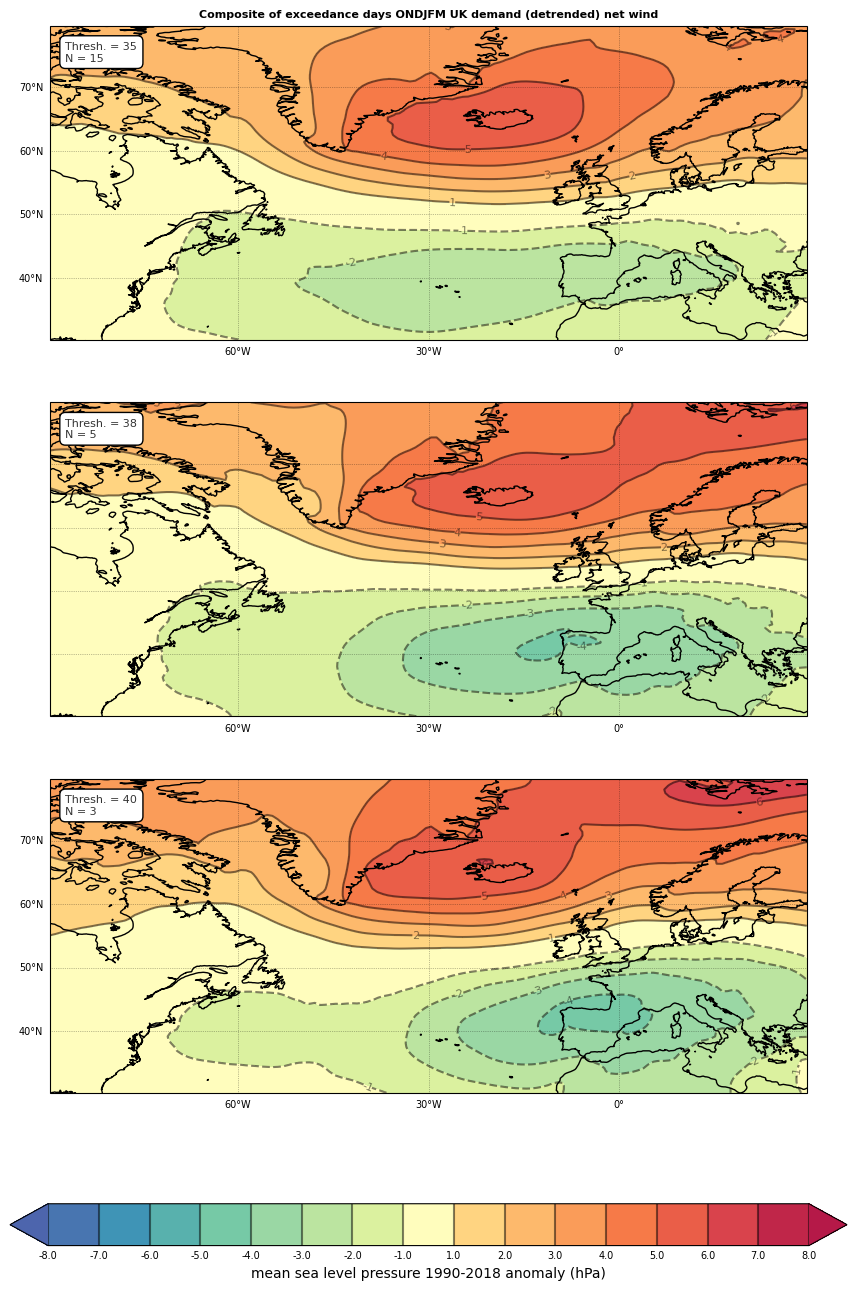

In [138]:
# N events from tqdm above
n_events_list = [15, 5, 3]

# hard code the climatology period
climatology_period = (1990, 2018)

# Set up the figure as 3 rows and 1 column
fig, axs = plt.subplots(
    3, 1, figsize=(12, 18), subplot_kw={"projection": ccrs.PlateCarree()}
)

# Assuming we are plotting anoms
clevs = np.array(
    [
        -8.0,
        -7.0,
        -6.0,
        -5.0,
        -4.0,
        -3.0,
        -2.0,
        -1.0,
        1.0,
        2.0,
        3.0,
        4.0,
        5.0,
        6.0,
        7.0,
        8.0,
    ]
)
ticks = clevs

# ensure that these are floats
clevs = clevs.astype(float)
ticks = ticks.astype(float)

# custom colormap
cs = [
    "#4D65AD",
    "#3E97B7",
    "#6BC4A6",
    "#A4DBA4",
    "#D8F09C",
    "#FFFEBE",
    "#FFD27F",
    "#FCA85F",
    "#F57244",
    "#DD484C",
    "#B51948",
]

cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", cs)

# loop over the fields
for i, thresh in enumerate(fields.keys()):
    mymap = axs[i].contourf(
        lons,
        lats,
        fields[thresh],
        clevs,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        extend="both",
    )

    # contour lines
    contours = axs[i].contour(
        lons,
        lats,
        fields[thresh],
        clevs,
        colors="black",
        transform=ccrs.PlateCarree(),
        linewidth=0.2,
        alpha=0.5,
    )

    # Set the labels for the contours
    axs[i].clabel(
        contours,
        clevs,
        fmt="%.4g",
        fontsize=8,
        inline=True,
        inline_spacing=0.0,
    )

for i, ax in enumerate(axs):
    # Set up the number of events
    num_event = n_events_list[i]

    # Set up the threshold
    thresh = list(fields.keys())[i]

    # add coastlines
    ax.coastlines()

    # format the gridlines and labels
    gl = ax.gridlines(
        draw_labels=True, linewidth=0.5, color="black", alpha=0.5, linestyle=":"
    )
    gl.xlabels_top = False
    gl.xlocator = mplticker.FixedLocator(np.arange(-180, 180, 30))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.xlabel_style = {"size": 7, "color": "black"}
    gl.ylabels_right = False
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylabel_style = {"size": 7, "color": "black"}

    # get rid of the top labels
    gl.top_labels = False

    # get rid of the right labels
    gl.right_labels = False

    # if the iteration is 1
    if i == 1:
        gl.left_labels = False

    # include a textbox in the top left
    ax.text(
        0.02,
        0.95,
        f"""Thresh. = {thresh}\nN = {num_event}""",
        verticalalignment="top",
        horizontalalignment="left",
        transform=ax.transAxes,
        color="black",
        fontsize=8,
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"),
        alpha=0.8,
    )

    # ===================================
    # TODO: add significance p-field here
    # ===================================

# Set up the colorbar
cbar = fig.colorbar(
    mymap,
    ax=axs,
    orientation="horizontal",
    shrink=0.9,
    pad=0.08,
    format=FuncFormatter(format_func_one_decimal),
)
# add colorbar label
cbar.set_label(
    f"mean sea level pressure {climatology_period[0]}-{climatology_period[1]} anomaly (hPa)",
    rotation=0,
    fontsize=10,
)

# add contour lines to the colorbar
cbar.add_lines(contours)

# Set up the title
axs[0].set_title(
    "Composite of exceedance days ONDJFM UK demand (detrended) net wind",
    fontsize=8,
    fontweight="bold",
)

cbar.ax.tick_params(labelsize=7, length=0)
cbar.set_ticks(ticks)

In [11]:
# test the bootstrapping
test_file = "/gws/nopw/j04/canari/users/benhutch/saved_DePre/HadGEM3-GC31-MM/psl/Amon/ONDJFM/1960-1961/HadGEM3-GC31-MM_psl_ONDJFM_Amon_1960-1961.npy"
test_file_lats = "/gws/nopw/j04/canari/users/benhutch/saved_DePre/HadGEM3-GC31-MM/psl/Amon/ONDJFM/1960-1961/HadGEM3-GC31-MM_psl_ONDJFM_Amon_1960-1961_lats.npy"
test_file_lons = "/gws/nopw/j04/canari/users/benhutch/saved_DePre/HadGEM3-GC31-MM/psl/Amon/ONDJFM/1960-1961/HadGEM3-GC31-MM_psl_ONDJFM_Amon_1960-1961_lons.npy"

# load the data
test_data = np.load(test_file)
test_lats = np.load(test_file_lats)
test_lons = np.load(test_file_lons)

# print the data
print(test_data.shape)
print(test_lats.shape)
print(test_lons.shape)

# subset and take the mean over the winters
# e.g. mean over indices [12, 13, 14, 15, 16, 17]
# [24, 25, 26, 27, 28, 29]
# [36, 37, 38, 39, 40, 41]
winter_years = np.arange(1, 10 + 1, 1)

# set up the new shape for the test data
new_test_data = np.zeros([test_data.shape[0], 10, len(winter_years), test_data.shape[3], test_data.shape[4]])

# print the shape of the test data
print(new_test_data.shape)

# # loop over the winter years
for i, year in enumerate(winter_years):
    # print the index
    print("index: ", i)
    
    # Set up the leads to extract
    leads_idx_this = np.arange((year * 12) - 1, (year * 12) - 1 + 6, 1)

    # print the shape of the leads idx this
    print(new_test_data[:, :, i, :, :].shape)
    print(new_test_data.shape)

    # print the shape of the test data
    print(test_data[:, :, leads_idx_this, :, :].shape)

    new_test_data[:, :, i, :, :] = np.mean(test_data[:, :, leads_idx_this, :, :], axis=2)

# # if test lons does not contain negative values, and the model lons do
# if not np.any(test_lons < 0) and np.any(lons > 0):
#     # print that we are converting the test lons to -180 to 180
#     print("Converting test lons to -180 to 180")

#     # convert the test lons to -180 to 180
#     test_lons = np.where(test_lons > 180, test_lons - 360, test_lons)

# # Find the indices of the test lats and test lons
# # which orrespond to the model lats and lons
# lats_idxs = np.argmin(np.abs(test_lats[:, None] - lats), axis=0)
# lons_idxs = np.argmin(np.abs(test_lons[:, None] - lons), axis=0)

# # # print the lats indices
# # print(lats_idxs)

# # subset the test lats to the model lats
# test_lats_subset = test_lats[lats_idxs]
# test_lons_subset = test_lons[lons_idxs]

# # print the model lats
# # print(lats)
# # print(test_lats_subset)

# # # print the model lons
# # print(lons)
# # print(test_lons_subset)

# # apply the indices to the test data
# test_data_subset = new_test_data[:, :, lats_idxs, :][:, :, :, lons_idxs]

# # print the shape of the test data subset
# print(test_data_subset.shape)

(2, 10, 125, 324, 432)
(324,)
(432,)
(2, 10, 10, 324, 432)
index:  0
(2, 10, 324, 432)
(2, 10, 10, 324, 432)
(2, 10, 6, 324, 432)
index:  1
(2, 10, 324, 432)
(2, 10, 10, 324, 432)
(2, 10, 6, 324, 432)
index:  2
(2, 10, 324, 432)
(2, 10, 10, 324, 432)
(2, 10, 6, 324, 432)
index:  3
(2, 10, 324, 432)
(2, 10, 10, 324, 432)
(2, 10, 6, 324, 432)
index:  4
(2, 10, 324, 432)
(2, 10, 10, 324, 432)
(2, 10, 6, 324, 432)
index:  5
(2, 10, 324, 432)
(2, 10, 10, 324, 432)
(2, 10, 6, 324, 432)
index:  6
(2, 10, 324, 432)
(2, 10, 10, 324, 432)
(2, 10, 6, 324, 432)
index:  7
(2, 10, 324, 432)
(2, 10, 10, 324, 432)
(2, 10, 6, 324, 432)
index:  8
(2, 10, 324, 432)
(2, 10, 10, 324, 432)
(2, 10, 6, 324, 432)
index:  9
(2, 10, 324, 432)
(2, 10, 10, 324, 432)
(2, 10, 6, 324, 432)


In [13]:
new_test_data.shape

(2, 10, 10, 324, 432)

In [15]:
test_lons

array([-179.58332825, -178.75      , -177.91667175, -177.08332825,
       -176.25      , -175.41667175, -174.58332825, -173.75      ,
       -172.91667175, -172.08332825, -171.25      , -170.41667175,
       -169.58332825, -168.75      , -167.91667175, -167.08332825,
       -166.25      , -165.41667175, -164.58332825, -163.75      ,
       -162.91667175, -162.08332825, -161.25      , -160.41667175,
       -159.58332825, -158.75      , -157.91667175, -157.08332825,
       -156.25      , -155.41667175, -154.58332825, -153.75      ,
       -152.91667175, -152.08332825, -151.25      , -150.41667175,
       -149.58332825, -148.75      , -147.91667175, -147.08332825,
       -146.25      , -145.41667175, -144.58332825, -143.75      ,
       -142.91667175, -142.08332825, -141.25      , -140.41667175,
       -139.58332825, -138.75      , -137.91667175, -137.08332825,
       -136.25      , -135.41667175, -134.58332825, -133.75      ,
       -132.91667175, -132.08332825, -131.25      , -130.41667

In [17]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from matplotlib import colors
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mplticker
from matplotlib.ticker import FuncFormatter
import matplotlib.gridspec as gridspec
import importlib

importlib.reload(sys.modules["functions"])
from functions import format_func, format_func_one_decimal

In [22]:
calc_anoms = False

NameError: name 'title' is not defined

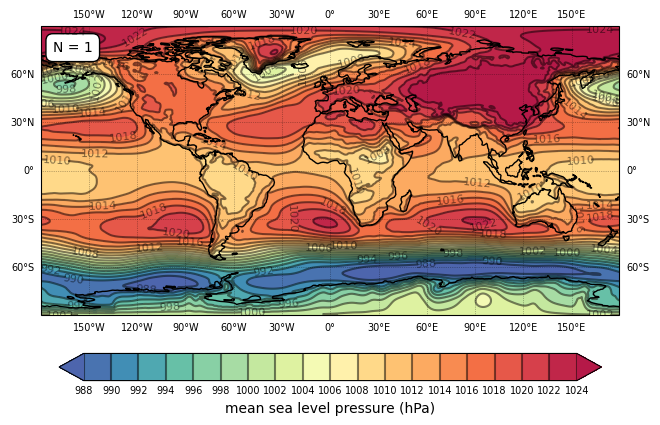

In [26]:
# set up the figure
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Set up the field
field = new_test_data[0, 0, 0, :, :]

# if calc_anoms is True
if calc_anoms:
    # clevs = np.linspace(-8, 8, 18)
    clevs = np.array(
        [
            -8.0,
            -7.0,
            -6.0,
            -5.0,
            -4.0,
            -3.0,
            -2.0,
            -1.0,
            1.0,
            2.0,
            3.0,
            4.0,
            5.0,
            6.0,
            7.0,
            8.0,
        ]
    )
    ticks = clevs

    # ensure that these are floats
    clevs = clevs.astype(float)
    ticks = ticks.astype(float)
else:
    # define the contour levels
    clevs = np.array(np.arange(988, 1024 + 1, 2))
    ticks = clevs

    # ensure that these are ints
    clevs = clevs.astype(int)
    ticks = ticks.astype(int)

# # print the shape of the inputs
# print(f"test_lons shape: {test_lons.shape}")
# print(f"test_lats shape: {test_lats.shape}")
# print(f"field shape: {field.shape}")
# print(f"clevs shape: {clevs.shape}")

# # print the field values
# print(f"field values: {field}")

# Define the custom diverging colormap
# cs = ["purple", "blue", "lightblue", "lightgreen", "lightyellow", "orange", "red", "darkred"]
# cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", cs)

# custom colormap
cs = [
    "#4D65AD",
    "#3E97B7",
    "#6BC4A6",
    "#A4DBA4",
    "#D8F09C",
    "#FFFEBE",
    "#FFD27F",
    "#FCA85F",
    "#F57244",
    "#DD484C",
    "#B51948",
]
# cs = ["#313695", "#4575b4", "#74add1", "#abd9e9", "#e0f3f8", "#ffffbf", "#fee090", "#fdae61", "#f46d43", "#d73027", "#a50026"]
cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", cs)

# plot the data
mymap = ax.contourf(
    test_lons, test_lats, field / 100, clevs, transform=ccrs.PlateCarree(), cmap=cmap, extend="both"
)
contours = ax.contour(
    test_lons,
    test_lats,
    field / 100,
    clevs,
    colors="black",
    transform=ccrs.PlateCarree(),
    linewidth=0.2,
    alpha=0.5,
)
if calc_anoms:
    ax.clabel(contours, clevs, fmt="%.1f", fontsize=8, inline=True, inline_spacing=0.0)
else:
    ax.clabel(contours, clevs, fmt="%.4g", fontsize=8, inline=True, inline_spacing=0.0)

# add coastlines
ax.coastlines()

# format the gridlines and labels
gl = ax.gridlines(
    draw_labels=True, linewidth=0.5, color="black", alpha=0.5, linestyle=":"
)
gl.xlabels_top = False
gl.xlocator = mplticker.FixedLocator(np.arange(-180, 180, 30))
gl.xformatter = LONGITUDE_FORMATTER
gl.xlabel_style = {"size": 7, "color": "black"}
gl.ylabels_right = False
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {"size": 7, "color": "black"}

# # set up the num events
# num_events = len(cube_psl.coord("number").points)
num_events = 1

# include a textbox in the top left
ax.text(
    0.02,
    0.95,
    f"N = {num_events}",
    verticalalignment="top",
    horizontalalignment="left",
    transform=ax.transAxes,
    color="black",
    fontsize=10,
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"),
)

if calc_anoms:
    cbar = plt.colorbar(
        mymap,
        orientation="horizontal",
        shrink=0.7,
        pad=0.1,
        format=FuncFormatter(format_func_one_decimal),
    )
    # add colorbar label
    cbar.set_label(
        f"mean sea level pressure {climatology_period[0]}-{climatology_period[1]} anomaly (hPa)",
        rotation=0,
        fontsize=10,
    )

    # add contour lines to the colorbar
    cbar.add_lines(contours)
else:
    # add colorbar
    cbar = plt.colorbar(
        mymap,
        orientation="horizontal",
        shrink=0.7,
        pad=0.1,
        format=FuncFormatter(format_func),
    )
    cbar.set_label("mean sea level pressure (hPa)", rotation=0, fontsize=10)

    # add contour lines to the colorbar
    cbar.add_lines(contours)
cbar.ax.tick_params(labelsize=7, length=0)
# set the ticks
cbar.set_ticks(ticks)

# add title
ax.set_title(title, fontsize=12, weight="bold")

# make plot look nice
plt.tight_layout()

In [28]:
# Test the ocean files
base_dir = "/gws/nopw/j04/canari/users/benhutch/saved_DePre/HadGEM3-GC31-MM/tos/Omon/ONDJFM/1960-1960"

# Set up the fnames
fnames = [
    "HadGEM3-GC31-MM_tos_ONDJFM_Omon_1960-1960.npy",
    "HadGEM3-GC31-MM_tos_ONDJFM_Omon_1960-1960_lats.npy",
    "HadGEM3-GC31-MM_tos_ONDJFM_Omon_1960-1960_lons.npy",
]

# Imoprt the data
tos_data = np.load(os.path.join(base_dir, fnames[0]))
tos_lats = np.load(os.path.join(base_dir, fnames[1]))
tos_lons = np.load(os.path.join(base_dir, fnames[2]))

In [30]:
# Subset to winter years
tos_data.shape

wyear_tos_data = np.zeros([tos_data.shape[0], 10, tos_data.shape[2], tos_data.shape[3]])

# loop over the winter years
for i, year in enumerate(winter_years):
    # Set up the leads to extract
    leads_idx_this = np.arange((year * 12) - 1, (year * 12) - 1 + 6, 1)

    wyear_tos_data[:, i, :, :] = np.mean(tos_data[:, leads_idx_this, :, :], axis=1)

In [34]:
# print the min and max of wyer tos data
# assert that not all values of tos data are nan
assert not np.all(np.isnan(wyear_tos_data)), "All values of wyear_tos_data are nan"

In [38]:
# print the max of wyear_tos_data (it contains nans)
print(np.nanmax(wyear_tos_data))
print(np.nanmin(wyear_tos_data))

33.86183166503906
-2.1040632724761963


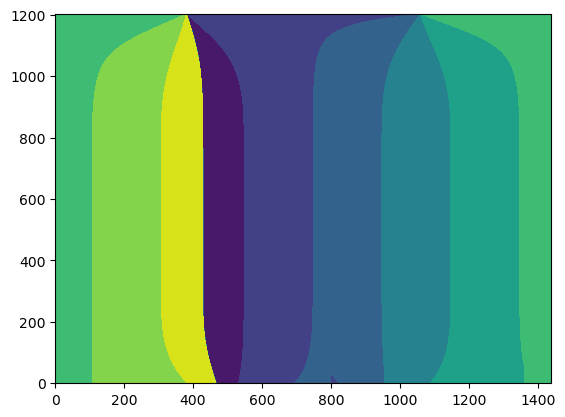

In [46]:
plt.contourf(tos_lons)

In [47]:
field.shape

(1205, 1440)

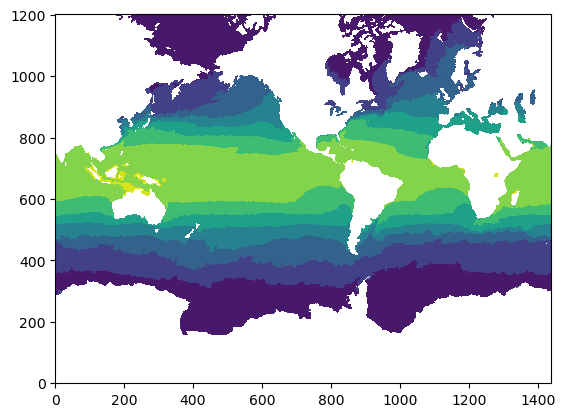

In [52]:
plt.contourf(tos_lons_

In [48]:
tos_lons.shape

(1205, 1440)

In [53]:
field.shape

(1205, 1440)

In [60]:
tos_lons_1d = tos_lons[0, :]
tos_lats_1d = tos_lats[:, 0]

# print the shape of these
print(tos_lons_1d.shape)
print(tos_lats_1d.shape)

(1440,)
(1205,)


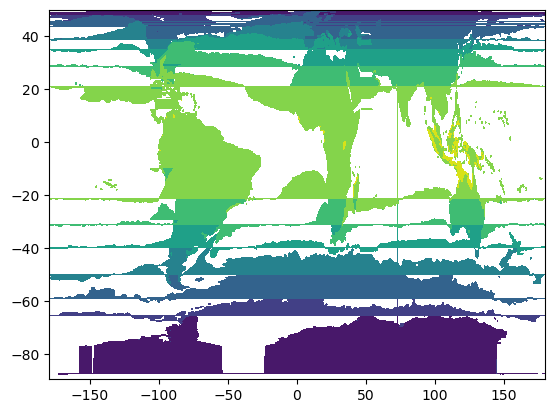

In [66]:
plt.contourf(tos_lons_1d, tos_lats_1d, field)

In [62]:
print(f"min tos lons: {tos_lons_1d.min()}")
print(f"max tos lons: {tos_lons_1d.max()}")

print(f"min tos lats: {tos_lats_1d.min()}")
print(f"max tos lats: {tos_lats_1d.max()}")

min tos lons: -179.65109252929688
max tos lons: 179.9067840576172
min tos lats: -89.48750305175781
max tos lats: 50.0


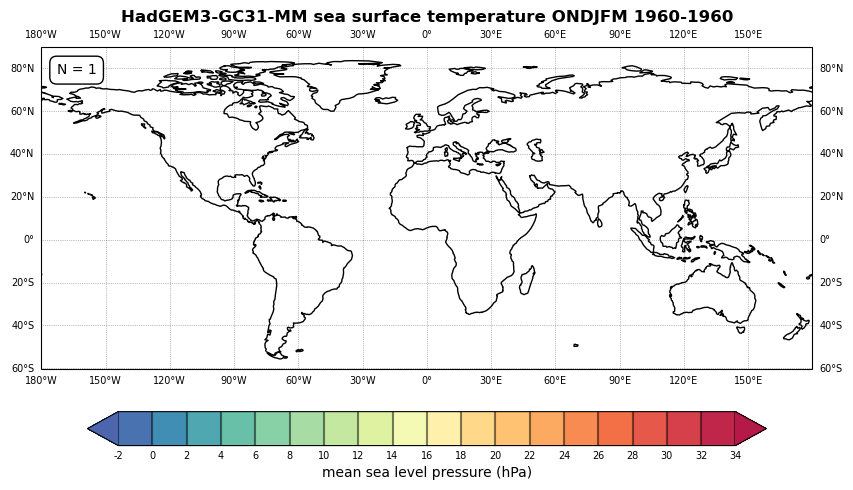

In [65]:
# set up the figure
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Set up the field
field = wyear_tos_data[0, 0, :, :]
title="HadGEM3-GC31-MM sea surface temperature ONDJFM 1960-1960"

# if calc_anoms is True
if calc_anoms:
    # clevs = np.linspace(-8, 8, 18)
    clevs = np.array(
        [
            -8.0,
            -7.0,
            -6.0,
            -5.0,
            -4.0,
            -3.0,
            -2.0,
            -1.0,
            1.0,
            2.0,
            3.0,
            4.0,
            5.0,
            6.0,
            7.0,
            8.0,
        ]
    )
    ticks = clevs

    # ensure that these are floats
    clevs = clevs.astype(float)
    ticks = ticks.astype(float)
else:
    # define the contour levels
    # clevs = np.array(np.arange(988, 1024 + 1, 2))
    clevs = np.array(np.arange(-2, 34 + 1, 2))
    ticks = clevs

    # ensure that these are ints
    clevs = clevs.astype(int)
    ticks = ticks.astype(int)

# # print the shape of the inputs
# print(f"tos_lons_1d shape: {tos_lons_1d.shape}")
# print(f"tos_lats_1d shape: {tos_lats_1d.shape}")
# print(f"field shape: {field.shape}")
# print(f"clevs shape: {clevs.shape}")

# # print the field values
# print(f"field values: {field}")

# Define the custom diverging colormap
# cs = ["purple", "blue", "lightblue", "lightgreen", "lightyellow", "orange", "red", "darkred"]
# cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", cs)

# custom colormap
cs = [
    "#4D65AD",
    "#3E97B7",
    "#6BC4A6",
    "#A4DBA4",
    "#D8F09C",
    "#FFFEBE",
    "#FFD27F",
    "#FCA85F",
    "#F57244",
    "#DD484C",
    "#B51948",
]
# cs = ["#313695", "#4575b4", "#74add1", "#abd9e9", "#e0f3f8", "#ffffbf", "#fee090", "#fdae61", "#f46d43", "#d73027", "#a50026"]
cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", cs)

# plot the data
mymap = ax.contourf(
    field, clevs, transform=ccrs.PlateCarree(), cmap=cmap, extend="both"
)
# contours = ax.contour(
#     tos_lons_1d,
#     tos_lats_1d,
#     field,
#     clevs,
#     colors="black",
#     transform=ccrs.PlateCarree(),
#     linewidth=0.2,
#     alpha=0.5,
# )
if calc_anoms:
    ax.clabel(contours, clevs, fmt="%.1f", fontsize=8, inline=True, inline_spacing=0.0)
else:
    ax.clabel(contours, clevs, fmt="%.4g", fontsize=8, inline=True, inline_spacing=0.0)

# add coastlines
ax.coastlines()

# format the gridlines and labels
gl = ax.gridlines(
    draw_labels=True, linewidth=0.5, color="black", alpha=0.5, linestyle=":"
)
gl.xlabels_top = False
gl.xlocator = mplticker.FixedLocator(np.arange(-180, 180, 30))
gl.xformatter = LONGITUDE_FORMATTER
gl.xlabel_style = {"size": 7, "color": "black"}
gl.ylabels_right = False
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {"size": 7, "color": "black"}

# # set up the num events
# num_events = len(cube_psl.coord("number").points)
num_events = 1

# include a textbox in the top left
ax.text(
    0.02,
    0.95,
    f"N = {num_events}",
    verticalalignment="top",
    horizontalalignment="left",
    transform=ax.transAxes,
    color="black",
    fontsize=10,
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"),
)

if calc_anoms:
    cbar = plt.colorbar(
        mymap,
        orientation="horizontal",
        shrink=0.7,
        pad=0.1,
        format=FuncFormatter(format_func_one_decimal),
    )
    # add colorbar label
    cbar.set_label(
        f"mean sea level pressure {climatology_period[0]}-{climatology_period[1]} anomaly (hPa)",
        rotation=0,
        fontsize=10,
    )

    # add contour lines to the colorbar
    cbar.add_lines(contours)
else:
    # add colorbar
    cbar = plt.colorbar(
        mymap,
        orientation="horizontal",
        shrink=0.7,
        pad=0.1,
        format=FuncFormatter(format_func),
    )
    cbar.set_label("mean sea level pressure (hPa)", rotation=0, fontsize=10)

    # add contour lines to the colorbar
    cbar.add_lines(contours)
cbar.ax.tick_params(labelsize=7, length=0)
# set the ticks
cbar.set_ticks(ticks)

# add title
ax.set_title(title, fontsize=12, weight="bold")

# make plot look nice
plt.tight_layout()

In [27]:
from functions import load_model_data_xarray

In [ ]:
# Test importing zg500


Now test the bootstrapping

Fields 40 is the mean of three winters

We want to generate 1000x 3 winter samples

And identify whether the mean lies outside the central 2.5th-97.5th %tile of the distribution.

In [140]:
# Reshape the test data subset
# from 10, 10, 90, 144
# to 100, 90, 144
# by reshaping the first two dimensions

test_data_subset_reshape = np.reshape(test_data_subset, (100, 90, 144))

In [144]:
np.shape(clim_field.data)

(90, 144)

In [149]:
# calculate the test data subset reshape anoms
test_data_subset_reshape_anoms = test_data_subset_reshape - (clim_field.data * 100)

In [150]:
test_data_subset_reshape_anoms

array([[[-2.66242188e+02, -2.72031250e+02, -2.73546875e+02, ...,
          8.30781250e+01,  8.40078125e+01,  8.62890625e+01],
        [-2.66851562e+02, -2.71398438e+02, -2.73078125e+02, ...,
          7.94843750e+01,  7.74531250e+01,  7.86953125e+01],
        [-2.65859375e+02, -2.70070312e+02, -2.71734375e+02, ...,
          7.25234375e+01,  7.00546875e+01,  7.05625000e+01],
        ...,
        [ 1.07656250e+01,  1.05234375e+01,  1.22343750e+01, ...,
          1.07054688e+02,  1.06507812e+02,  1.07320312e+02],
        [ 1.60781250e+01,  1.58515625e+01,  6.82031250e+00, ...,
          1.27429688e+02,  1.29335938e+02,  1.32257812e+02],
        [ 2.11328125e+01,  2.17343750e+01,  1.51718750e+01, ...,
          1.50328125e+02,  1.47429688e+02,  1.50906250e+02]],

       [[-6.25937500e+01, -6.72578125e+01, -7.39843750e+01, ...,
          1.33273438e+02,  1.26679688e+02,  1.20453125e+02],
        [-6.58750000e+01, -6.96250000e+01, -7.46796875e+01, ...,
          1.33710938e+02,  1.22117188e

In [151]:
%%time

import random

# Fields 40 is the mean of 3 winters
n_events = 3
nboot = 1000 # for testing purposes

# Set up the index for members and winter years
index_ens = range(test_data_subset_reshape_anoms.shape[0])

# Set up the composite means
composite_means = np.zeros([nboot, test_data_subset_reshape_anoms.shape[1], test_data_subset_reshape_anoms.shape[2]])

# Loop over the number of bootstraps
for iboot in tqdm(np.arange(nboot)):
    # Create an array containing random indices
    ind_ens_this = np.array([random.choice(index_ens) for i in range(n_events)])

    # Set up the composite mean
    composite_means[iboot, :, :] = np.mean(test_data_subset_reshape_anoms[ind_ens_this, :, :], axis=0)

# print the shape of the composite means
print(composite_means.shape)

# # print the composite means
# print(composite_means)

100%|██████████| 1000/1000 [00:00<00:00, 10941.33it/s]

(1000, 90, 144)
CPU times: user 78.3 ms, sys: 16.9 ms, total: 95.2 ms
Wall time: 94.3 ms


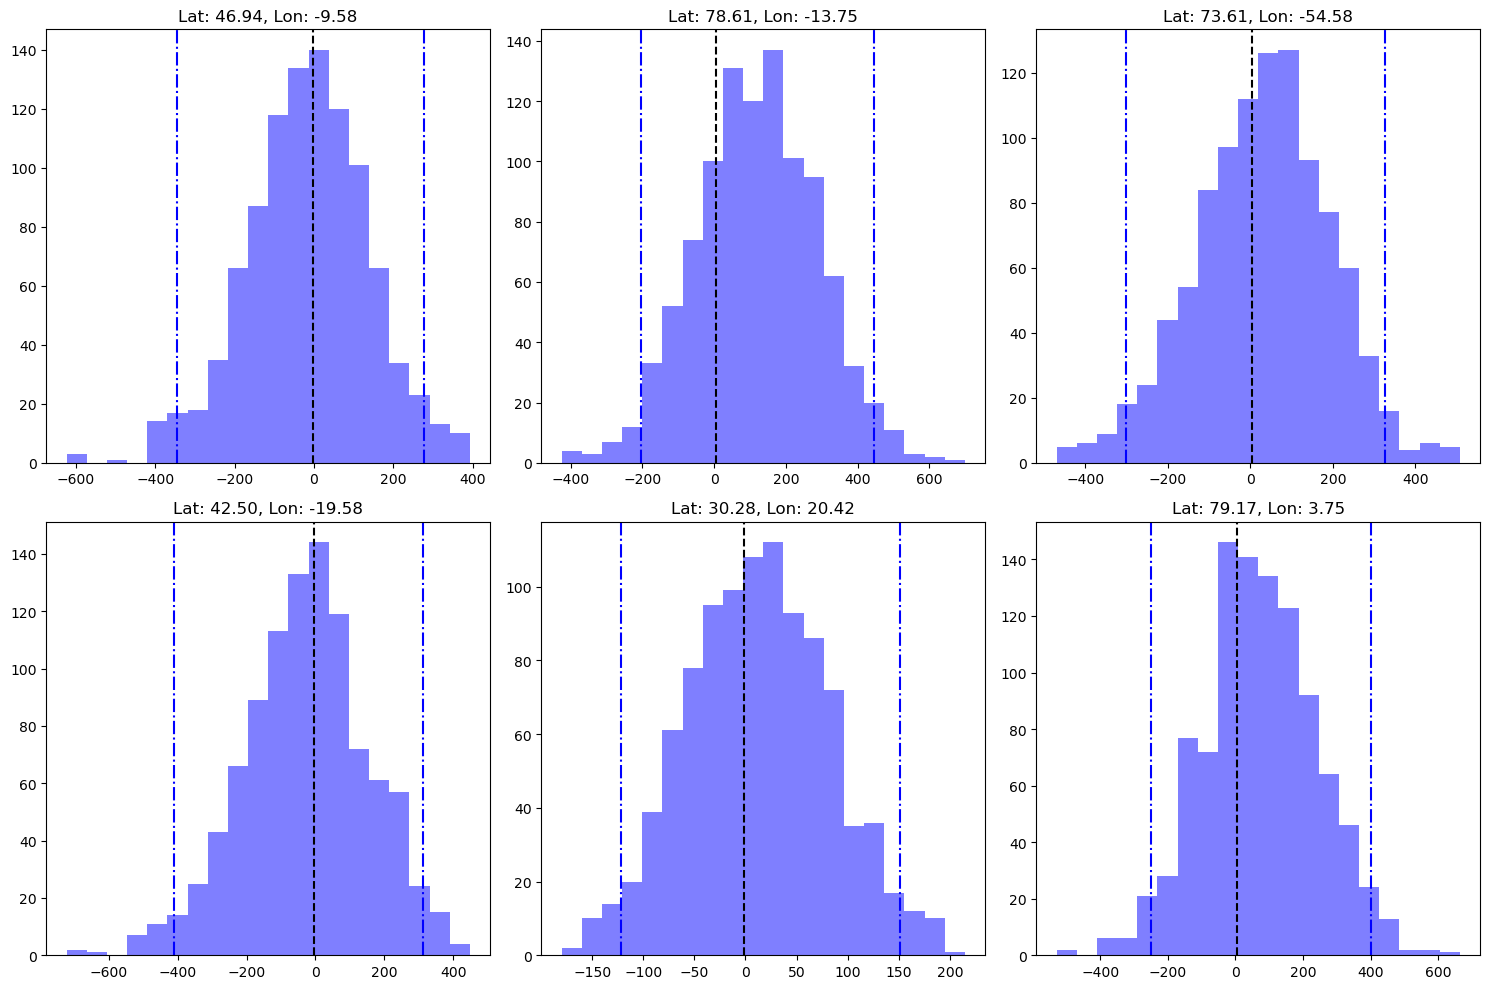

In [160]:
# choose 6 random lats and lons
random_lats = np.random.choice(test_lats_subset, 6)
random_lons = np.random.choice(test_lons_subset, 6)

# Set up a figure with 3 columns and 2 rows
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# flatten the axes
axs = axs.flatten()

# Loop over the random lats and lons
for k, (lat, lon) in enumerate(zip(random_lats, random_lons)):
    # Find the indices of the lat and lon
    lat_indices = np.where(test_lats_subset == lat)[0]
    lon_indices = np.where(test_lons_subset == lon)[0]

    # do the same for the model lats and lons
    model_lat_indices = np.where(lats == lat)[0]
    model_lon_indices = np.where(lons == lon)[0]

    # Check if indices are found
    if len(lat_indices) > 0 and len(lon_indices) > 0:
        lat_idx = lat_indices[0]
        lon_idx = lon_indices[0]

        # Set up the data
        data = composite_means[:, lat_idx, lon_idx]

        # Set up the histogram
        axs[k].hist(data, bins=20, color="blue", alpha=0.5)

        # plot a vertical black line for the model mean
        model_mean = (fields[40][model_lat_indices, model_lon_indices])

        # plot the model mean
        axs[k].axvline(model_mean, color="black", linestyle="--")

        # Set up the title
        axs[k].set_title(f"Lat: {lat:.2f}, Lon: {lon:.2f}")

        # include the 2.5th and 97.5th percentiles of the distribution
        axs[k].axvline(np.percentile(data, 2.5), color="blue", linestyle="-.")
        axs[k].axvline(np.percentile(data, 97.5), color="blue", linestyle="-.")
    else:
        # Handle the case where the lat or lon is not found
        axs[k].set_title(f"Lat: {lat:.2f}, Lon: {lon:.2f}" + "\nData not found")
        axs[k].text(0.5, 0.5, 'Data not found', horizontalalignment='center', verticalalignment='center', transform=axs[k].transAxes)

# Adjust layout
plt.tight_layout()
plt.show()

In [105]:
exceedance_days = [20, 30, 40]
model_df = df_model_exceedance
model_val_name = "no_exceedance_days_demand_net_wind"

In [108]:
# First subset the data to specific thresholds
# Set up a dictionary for the exceedance
exceed_dict = {}

# Loop over the exceedance days
for exceed_day in exceedance_days:
    # print the threshold
    print(f"Threshold: {exceed_day}")

    # Filter the model df to be only the
    # days greater than the threshold
    model_df_exceedance = model_df[model_df[model_val_name] > exceed_day]

    # # print the head of the model df
    # print(model_df_exceedance.head())

    # # print the shape of the model df
    # print(model_df_exceedance.shape)

    # extract a list of len three tuples
    # containing the init year, member and winter year
    exceedance_list = list(
        zip(
            model_df_exceedance["init_year"],
            model_df_exceedance["winter_year"],
            model_df_exceedance["member"],
        )
    )

    # # # print the first 5 elements of the list
    # print(exceedance_list[:5])

    # # print the len of the list
    # print(len(exceedance_list))

    # Append the threshold to the dictionary
    exceed_dict[exceed_day] = exceedance_list

Threshold: 20
Threshold: 30
Threshold: 40


In [113]:
nboot = 1000
obs_variable = "msl"
model = "HadGEM3-GC31-MM"
psl_variable = "psl"
freq = "Amon"
experiment = "dcppA-hindcast"
calc_anoms = False
months = [10, 11, 12, 1, 2, 3]
climatology_period = [1990, 2018]
lat_bounds = [30, 80]
lon_bounds = [-90, 30]
files_loc_path = (
    "/home/users/benhutch/unseen_multi_year/paths/paths_20240117T122513.csv"
)
save_prefix = "composite_obs_model"
save_dir = "/gws/nopw/j04/canari/users/benhutch/plots/unseen"
regrid_file = "/gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r1i1_gn_196011-197103.nc"

In [124]:
import glob

# Load the files location
files_loc = pd.read_csv(files_loc_path)

# print the data we seek
print(f"model: {model}")
print(f"experiment: {experiment}")
print(f"freq: {freq}")
print(f"psl_variable: {psl_variable}")

# Extract the path for the given model, experiment, freq, and variable
model_path_psl = files_loc.loc[
    (files_loc["model"] == model)
    & (files_loc["experiment"] == experiment)
    & (files_loc["frequency"] == freq)
    & (files_loc["variable"] == psl_variable)
]["path"].values[0]

# asser that the model path psl exists
assert os.path.exists(model_path_psl), "The model path psl does not exist"

# extract the model path root
model_path_root_psl = model_path_psl.split("/")[1]

# Set up an empty list of files
files_list = []

files_list_exceed = {}

# Loop over the exceedance days
for thresh in exceed_dict:
    # print the threshold
    print(f"Threshold: {thresh}")

    # Set up an empty list for the files for this threshold
    files_list = []

    # Loop over the exceedance list
    for i, (init_year, winter_year, member) in enumerate(exceed_dict[thresh]):
        # print the init year, winter year and member
        print(f"Init year: {init_year}, Winter year: {winter_year}, Member: {member}")

        if model_path_root_psl == "work":
            raise NotImplementedError("work path not implemented yet")
        elif model_path_root_psl == "gws":
            # Create the path
            path = f"{model_path_psl}/{psl_variable}_{freq}_{model}_{experiment}_s{init_year}-r{member}i*_*_{init_year}??-*.nc"

            # glob this path
            files = glob.glob(path)

            # assert that files has length 1
            assert len(files) == 1, f"files has length {len(files)}"

            # extract the file
            file = files[0]

            # assert that this file exists
            assert os.path.exists(file), f"{file} does not exist"

        elif model_path_root_psl == "badc":
            raise NotImplementedError("home path not implemented yet")
        else:
            raise ValueError(f"Unknown model path root {model_path_root_psl}")

        # append the file to the files list
        files_list.append(file)

    # assign the files list to the files_list_exceed dictionary for this threshold
    files_list_exceed[thresh] = files_list

model: HadGEM3-GC31-MM
experiment: dcppA-hindcast
freq: Amon
psl_variable: psl
Threshold: 20
Init year: 1960, Winter year: 8, Member: 1
Init year: 1960, Winter year: 10, Member: 1
Init year: 1960, Winter year: 1, Member: 2
Init year: 1960, Winter year: 2, Member: 2
Init year: 1960, Winter year: 8, Member: 2
Init year: 1960, Winter year: 6, Member: 4
Init year: 1960, Winter year: 3, Member: 5
Init year: 1960, Winter year: 3, Member: 7
Init year: 1960, Winter year: 10, Member: 7
Init year: 1960, Winter year: 7, Member: 8
Init year: 1960, Winter year: 1, Member: 9
Init year: 1960, Winter year: 5, Member: 10
Init year: 1961, Winter year: 2, Member: 1
Init year: 1961, Winter year: 10, Member: 1
Init year: 1961, Winter year: 5, Member: 2
Init year: 1961, Winter year: 7, Member: 4
Init year: 1961, Winter year: 8, Member: 4
Init year: 1961, Winter year: 9, Member: 6
Init year: 1961, Winter year: 4, Member: 10
Init year: 1961, Winter year: 6, Member: 10
Init year: 1962, Winter year: 5, Member: 

In [131]:
files_list_exceed[40]

['/gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1981-r4i1_gn_198111-199203.nc',
 '/gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1992-r9i1_gn_199211-200303.nc',
 '/gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s2013-r2i1_gn_201311-202403.nc']

In [134]:
importlib.reload(sys.modules["functions"])
from functions import set_integer_time_axis

In [137]:
df_model_exceedance["winter_year"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [210]:
def preprocess_leads(
    ds,
    winter_year,
    freq,
    idx,
):
    """
    Preprocess the leads of the model data
    """

    # format the lead as an int
    ds = set_integer_time_axis(
        xro=ds,
        frequency=freq,
    )

    # # print the leads in ds
    # print(ds.time)

    # Use the winter year to find the leads to extract
    # for ONDJFM
    leads_extract = np.arange(winter_year * 12, winter_year * 12 + 6, 1)

    # # print the leads extract
    # print(leads_extract)

    # # print the indexes of time
    # print(ds.time)

    # Extract the leads
    ds = ds.sel(time=leads_extract).mean("time")

    # Add a new coordinate 'number' with a unique value
    ds = ds.expand_dims({"number": [idx]})

    return ds

In [223]:
# Form the concatenated dataset for the exceedance days
# loop over the thresholds
for thresh in [20]:
    # extract the files list
    files_list = files_list_exceed[thresh]

    # extract the exceedance list
    exceed_list = exceed_dict[thresh]

    # print both
    print(files_list)
    print(exceed_list)

    ds_list = []

    # Loop over the files
    for idx, (file, (init_year, winter_year, member)) in tqdm(
        enumerate(zip(files_list, exceed_list))
    ):
        # print the file, init year, winter year and member
        # print(f"File: {file}, Init year: {init_year}, Winter year: {winter_year}, Member: {member}")

        # Load the data
        ds = xr.open_mfdataset(
            file,
            preprocess=lambda ds: preprocess_leads(
                ds=ds,
                winter_year=winter_year,
                freq=freq,
                idx=idx,
            ),
        )

        # append the ds_extract to the list
        ds_list.append(ds[psl_variable])

    # Concatenate the list of datasets
    combined_ds = xr.concat(ds_list, dim="number")

['/gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r1i1_gn_196011-197103.nc', '/gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r1i1_gn_196011-197103.nc', '/gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r2i1_gn_196011-197103.nc', '/gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r2i1_gn_196011-197103.nc', '/gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r2i1_gn_196011-197103.nc', '/gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1960-r4i1_gn_196011-197103.nc', '/gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/psl/HadGEM3-GC31-MM/psl_Amon_HadGEM3-GC31-

44it [05:29,  7.49s/it]


KeyboardInterrupt: 

In [212]:
# convert to a cube
cube_psl = combined_ds.to_iris()

# subset to teh correct grid
cube_psl = cube_psl.intersection(longitude=(-180, 180), latitude=(-90, 90))

# subset to the region of interest
cube_psl = cube_psl.intersection(
    longitude=(lon_bounds[0], lon_bounds[1]),
    latitude=(lat_bounds[0], lat_bounds[1]),
)

In [213]:
calc_anoms = True

In [214]:
# if calc anoms is true
if calc_anoms:

    # set up a save directory for the climatologies
    save_dir_clim = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_clim"

    # assert that this directory exists
    assert os.path.exists(save_dir_clim), "The save directory does not exist"

    # set up the fname
    fname = f"climatology_{model}_{experiment}_{freq}_{psl_variable}_{climatology_period[0]}-{climatology_period[1]}_{lat_bounds[0]}-{lat_bounds[1]}_{lon_bounds[0]}-{lon_bounds[1]}_{months[0]}-{months[-1]}.nc"

    # set up the full climatology path
    climatology_path = os.path.join(save_dir_clim, fname)

    # if the climatology path exists
    if os.path.exists(climatology_path):
        print("The climatology file exists")
        print("Loading the climatology file")

        # load the file using iris
        cube_clim = iris.load_cube(climatology_path)

    else:
        print("The climatology file does not exist")
        print("Calculating the climatology")

        # Set up a list for the full ds's
        clim_dss = []
        # Loop over the years
        for year in tqdm(range(climatology_period[0], climatology_period[1] + 1)):
            member_list = []
            for member in unique_members:
                start_time = time.time()

                path = f"{model_path_psl}/{psl_variable}_{freq}_{model}_{experiment}_s{year}-r{member}i*_*_{year}??-*.nc"

                # glob this path
                glob_start = time.time()
                files = glob.glob(path)
                glob_end = time.time()

                # assert
                assert (
                    len(files) == 1
                ), f"files has length {len(files)} for year {year} and member {member} and path {path}"

                # open all of the files
                # open_start = time.time()
                member_ds = xr.open_mfdataset(
                    files[0],
                    combine="nested",
                    concat_dim="time",
                    preprocess=lambda ds: preprocess(
                        ds=ds,
                        year=year,
                        variable=psl_variable,
                        months=months,
                    ),
                    parallel=True,
                    engine="netcdf4",
                    coords="minimal",  # expecting identical coords
                    data_vars="minimal",  # expecting identical vars
                    compat="override",  # speed up
                ).squeeze()
                # open_end = time.time()

                # id init year == climatology_period[0]
                # and member == unique_members[0]
                # set_time_start = time.time()
                if year == climatology_period[0] and member == unique_members[0]:
                    # set the new integer time
                    member_ds = set_integer_time_axis(
                        xro=member_ds,
                        frequency=freq,
                        first_month_attr=True,
                    )
                else:
                    # set the new integer time
                    member_ds = set_integer_time_axis(
                        xro=member_ds,
                        frequency=freq,
                    )
                # set_time_end = time.time()

                # take the mean over the time axis
                # mean_start = time.time()
                member_ds = member_ds.mean(dim="time")
                # mean_end = time.time()

                # append the member_ds to the member_list
                member_list.append(member_ds)

                # end_time = time.time()

                # # Print timing information
                # print(f"Year: {year}, Member: {member}")
                # print(f"  Total time: {end_time - start_time:.2f} seconds")
                # print(f"  glob time: {glob_end - glob_start:.2f} seconds")
                # print(f"  open_mfdataset time: {open_end - open_start:.2f} seconds")
                # print(f"  set_integer_time_axis time: {set_time_end - set_time_start:.2f} seconds")
                # print(f"  mean time: {mean_end - mean_start:.2f} seconds")

            # Concatenate with a new member dimension using xarray
            member_ds = xr.concat(member_list, dim="member")
            # append the member_ds to the init_year_list
            clim_dss.append(member_ds)
        # Concatenate the init_year list along the init dimension
        # and rename as lead time
        ds = xr.concat(clim_dss, "init")

        # print ds
        print(ds)

        # set up the members
        ds["member"] = unique_members
        ds["init"] = np.arange(climatology_period[0], climatology_period[1] + 1)

        # extract the variable
        ds_var = ds[psl_variable]

        # # take the mean over lead dimension
        # ds_clim = ds_var.mean(dim="lead")

        # take the mean over member dimension
        ds_clim = ds_var.mean(dim="member")

        # take the mean over init dimension
        ds_clim = ds_clim.mean(dim="init")

        # convert to a cube
        cube_clim = ds_clim.to_iris()

        # # regrid the model data to the obs grid
        # cube_clim_regrid = cube_clim.regrid(cube_obs, iris.analysis.Linear())

        # subset to the correct grid
        cube_clim = cube_clim.intersection(longitude=(-180, 180), latitude=(-90, 90))

        # subset to the region of interest
        cube_clim = cube_clim.intersection(
            latitude=(lat_bounds[0], lat_bounds[1]),
            longitude=(lon_bounds[0], lon_bounds[1]),
        )

        # if the climatology file does not exist
        print("Saving the climatology file")

        # save the cube_clim
        iris.save(cube_clim, climatology_path)

The climatology file exists
Loading the climatology file


In [215]:
cube_clim

<iris 'Cube' of psl / (unknown) (latitude: 90; longitude: 144)>

In [216]:
cube_psl

Psl (unknown),number,latitude,longitude
Shape,73,90,144
Dimension coordinates,,,
number,x,-,-
latitude,-,x,-
longitude,-,-,x


In [217]:
# take the mean of cube_psl over number and time
cube_psl_mean = cube_psl.collapsed(["number"], iris.analysis.MEAN)

In [218]:
# calculate the anomalies
field = (cube_psl_mean.data - cube_clim.data) / 100

In [219]:
lons = cube_psl.coord("longitude").points
lats = cube_psl.coord("latitude").points

In [220]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from matplotlib import colors
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mplticker
from matplotlib.ticker import FuncFormatter
import matplotlib.gridspec as gridspec

importlib.reload(sys.modules["functions"])
from functions import format_func, format_func_one_decimal

NameError: name 'title' is not defined

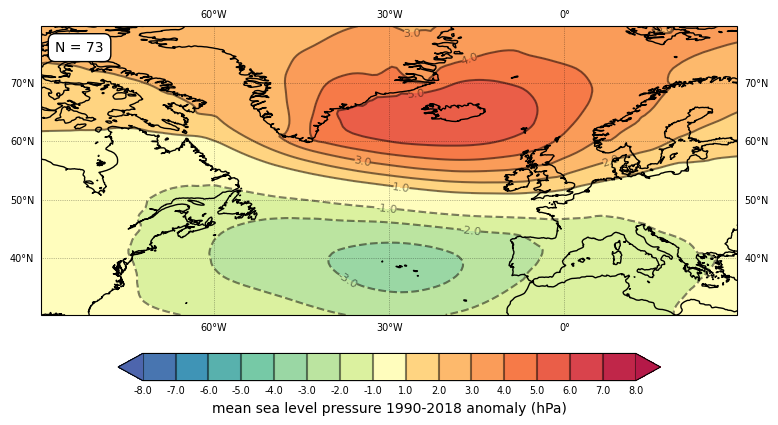

In [222]:
# set up the figure
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))

# if calc_anoms is True
if calc_anoms:
    # clevs = np.linspace(-8, 8, 18)
    clevs = np.array(
        [
            -8.0,
            -7.0,
            -6.0,
            -5.0,
            -4.0,
            -3.0,
            -2.0,
            -1.0,
            1.0,
            2.0,
            3.0,
            4.0,
            5.0,
            6.0,
            7.0,
            8.0,
        ]
    )
    ticks = clevs

    # ensure that these are floats
    clevs = clevs.astype(float)
    ticks = ticks.astype(float)
else:
    # define the contour levels
    clevs = np.array(np.arange(988, 1024 + 1, 2))
    ticks = clevs

    # ensure that these are ints
    clevs = clevs.astype(int)
    ticks = ticks.astype(int)

# # print the shape of the inputs
# print(f"lons shape: {lons.shape}")
# print(f"lats shape: {lats.shape}")
# print(f"field shape: {field.shape}")
# print(f"clevs shape: {clevs.shape}")

# # print the field values
# print(f"field values: {field}")

# Define the custom diverging colormap
# cs = ["purple", "blue", "lightblue", "lightgreen", "lightyellow", "orange", "red", "darkred"]
# cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", cs)

# custom colormap
cs = [
    "#4D65AD",
    "#3E97B7",
    "#6BC4A6",
    "#A4DBA4",
    "#D8F09C",
    "#FFFEBE",
    "#FFD27F",
    "#FCA85F",
    "#F57244",
    "#DD484C",
    "#B51948",
]
# cs = ["#313695", "#4575b4", "#74add1", "#abd9e9", "#e0f3f8", "#ffffbf", "#fee090", "#fdae61", "#f46d43", "#d73027", "#a50026"]
cmap = colors.LinearSegmentedColormap.from_list("custom_cmap", cs)

# plot the data
mymap = ax.contourf(
    lons, lats, field, clevs, transform=ccrs.PlateCarree(), cmap=cmap, extend="both"
)
contours = ax.contour(
    lons,
    lats,
    field,
    clevs,
    colors="black",
    transform=ccrs.PlateCarree(),
    linewidth=0.2,
    alpha=0.5,
)
if calc_anoms:
    ax.clabel(contours, clevs, fmt="%.1f", fontsize=8, inline=True, inline_spacing=0.0)
else:
    ax.clabel(contours, clevs, fmt="%.4g", fontsize=8, inline=True, inline_spacing=0.0)

# add coastlines
ax.coastlines()

# format the gridlines and labels
gl = ax.gridlines(
    draw_labels=True, linewidth=0.5, color="black", alpha=0.5, linestyle=":"
)
gl.xlabels_top = False
gl.xlocator = mplticker.FixedLocator(np.arange(-180, 180, 30))
gl.xformatter = LONGITUDE_FORMATTER
gl.xlabel_style = {"size": 7, "color": "black"}
gl.ylabels_right = False
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {"size": 7, "color": "black"}

# set up the num events
num_events = len(cube_psl.coord("number").points)

# include a textbox in the top left
ax.text(
    0.02,
    0.95,
    f"N = {num_events}",
    verticalalignment="top",
    horizontalalignment="left",
    transform=ax.transAxes,
    color="black",
    fontsize=10,
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.5"),
)

if calc_anoms:
    cbar = plt.colorbar(
        mymap,
        orientation="horizontal",
        shrink=0.7,
        pad=0.1,
        format=FuncFormatter(format_func_one_decimal),
    )
    # add colorbar label
    cbar.set_label(
        f"mean sea level pressure {climatology_period[0]}-{climatology_period[1]} anomaly (hPa)",
        rotation=0,
        fontsize=10,
    )

    # add contour lines to the colorbar
    cbar.add_lines(contours)
else:
    # add colorbar
    cbar = plt.colorbar(
        mymap,
        orientation="horizontal",
        shrink=0.7,
        pad=0.1,
        format=FuncFormatter(format_func),
    )
    cbar.set_label("mean sea level pressure (hPa)", rotation=0, fontsize=10)

    # add contour lines to the colorbar
    cbar.add_lines(contours)
cbar.ax.tick_params(labelsize=7, length=0)
# set the ticks
cbar.set_ticks(ticks)

# add title
ax.set_title(title, fontsize=12, weight="bold")

# make plot look nice
plt.tight_layout()